<a href="https://colab.research.google.com/github/jcarrizo7r/DS1/blob/main/ProyectoDS1_ParteFinal_Carrizo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Descripción del proyecto
---
Este proyecto tiene como objetivo analizar y construir un modelo predictivo de los rendimientos diarios de la acción de Microsoft (MSFT), explorando la evolución de las cotizaciones en conjunto con otras activos similares del sector tecnológico. Se pretende añadir al análisis las series de tiempo de los principales índices de acciones del mercado financiero estadounidense (S&P500 y NASDAQ), como también de los índices relacionados a la volatilidad (VIX) y a las tasas de interés de los bonos del Tesoro americano (TNX). Se pretende analizar el grado de las correlaciones entre las principales acciones tecnológicas de mayor capitalización bursátil, la evolución del índice S&P500 como referencia del mercado y la influencia de la tasa de política monetaria de Estados Unidos en las variables analizadas.

Algunas preguntas a responder son:

- ¿Cuánto se puede explicar de los retornos de una acción en función de factores endógenos (evolución histórica, volumen de operaciones, volatilidad de los precios)?
- ¿Cuánto se puede explicar de los retornos de la acción en función de factores exógenos (movimientos del mercado, volatilidad del mercado, tasa de interés)?
- ¿La volatilidad general del mercado afecta negativamente los rendimientos?
- ¿Una mayor volatilidad en las cotizaciones está asociada a un mayor retorno?
- ¿Qué tan preciso es el modelo para predecir los rendimientos futuros de la acción?


Para responder a estas preguntas, se realizará un análisis exploratorio de datos, se seleccionarán las variables más prometedoras, se crearán modelos predictivos de aprendizaje supervisado y se evaluarán sus precisiones.



#2. Obtención de datos
---
Para la obtención de datos se utiliza la API de Yahoo Finance a través de la biblioteca yfinance (ver: https://aroussi.com/post/python-yahoo-finance)
###Referencias:
#### Índices:
- **GSPC (S&P500)**: El índice Standard & Poor's 500 pondera las 500 empresas de mayor capitalización bursátil de Estados Unidos; se le considera el índice más representativo de la situación real del mercado.
- **IXIC**: El Nasdaq Composite incluye casi todas las acciones que cotizan en la bolsa de valores Nasdaq y su composición está fuertemente ponderada hacia las empresas del sector de Tecnología de la Información (IT).
- **VIX**: Muestra la volatilidad implícita de las Opciones sobre el índice  para un periodo de 30 días; sirve de referencia de la volatilidad general del mercado (las subidas en el VIX suelen acompañar bajas en el S&P500).
- **TNX**: Índice que muestra la evolución de la tasa de interés del bono del Tesoro Americano a 10 años (sirve de referencia a la tasa de política monetaria de Estados Unidos, que es la tasa de interés de los Fondos Federales, la cual impacta directamente en las tasas de los bonos del Tesoro). Esta tasa es conocida como la tasa libre de riesgo.

#### Acciones:
Principales 5 acciones tecnológicas por Capitalización Bursátil:
- **MSFT**: Microsoft Corp.
- **AAPL**: Apple, Inc.
- **NVDA**: Nvidia Corp.
- **AMZN**: Amazon.com, Inc.
- **GOOGL**: Alphabet (Google), Inc.

####Información de las series históricas:
De cada acción se obtienen series de tiempo con las cotizaciones históricas de precios de apertura (Open), cierre (Close), máximo (High), mínimo (Low) y volumen de operaciones (Volume), también conocidas como OCHLV.

Cabe destacar que la API utilizada facilita la obtención de las series ajustadas, es decir, con los valores de precios y volúmenes de operación corregidos. Esto es importante debido al efecto que tienen las llamadas acciones corporativas, en las que principalmente se incluyen los eventos de pago de dividendos (Dividends) y división de acciones (Splits), las cuales afectan los valores históricos de las series.

In [ ]:
#importando las bibliotecas necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
from datetime import datetime


In [ ]:
# definiendo el período para la extracción de los datos
end_time = datetime(2024,6,30)
start_time = datetime(end_time.year - 20,end_time.month,end_time.day)

print(f"Desde: {start_time}")
print(f"Hasta: {end_time}")
print(f"Periodo: {end_time.year - start_time.year} años")

Desde: 2004-06-30 00:00:00
Hasta: 2024-06-30 00:00:00
Periodo: 20 años


In [ ]:
# importando datos desde la API de Yahoo Finance

# principales acciones tecnológicas e índices
stocks_tickers = ["MSFT","AAPL","NVDA","AMZN","GOOGL"]
indexes_tickers = ["^GSPC","^IXIC","^VIX","^TNX"]

# inicializando diccionarios
stocks ={}
indexes = {}

# extrayendo las series históricas diarias OCHLV
for ticker in stocks_tickers:
    stocks[ticker] = yf.Ticker(ticker).history(start=start_time, end=end_time)

for ticker in indexes_tickers:
    indexes[ticker] = yf.Ticker(ticker).history(start=start_time, end=end_time)


In [ ]:
#visualizando DataFrame de MSFT
stocks["MSFT"].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-06-30 00:00:00-04:00,17.771876,17.914947,17.659908,17.765656,83544400,0.0,0.0
2004-07-01 00:00:00-04:00,17.852746,17.939833,17.579046,17.809202,78441400,0.0,0.0
2004-07-02 00:00:00-04:00,17.802978,17.840301,17.666127,17.771875,36690100,0.0,0.0
2004-07-06 00:00:00-04:00,17.616360,17.622581,17.379983,17.429747,69158900,0.0,0.0
2004-07-07 00:00:00-04:00,17.212039,17.616369,17.137392,17.479519,66255700,0.0,0.0


In [ ]:
#reasignando los índices de acuerdo solo a la fecha
for ticker in stocks_tickers:
    stocks[ticker].index = pd.to_datetime(stocks[ticker].index).date
    stocks[ticker].index.name = "Date"

for ticker in indexes_tickers:
    indexes[ticker].index = pd.to_datetime(indexes[ticker].index).date
    indexes[ticker].index.name = "Date"


In [ ]:
#visualizando Dataframe del índice del S&P500
indexes["^GSPC"]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-06-30,1136.199951,1144.199951,1133.619995,1140.839966,1473800000,0.0,0.0
2004-07-01,1140.839966,1140.839966,1123.060059,1128.939941,1495700000,0.0,0.0
2004-07-02,1128.939941,1129.150024,1123.260010,1125.380005,1085000000,0.0,0.0
2004-07-06,1125.380005,1125.380005,1113.209961,1116.209961,1283300000,0.0,0.0
2004-07-07,1116.209961,1122.369995,1114.920044,1118.329956,1328600000,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-24,5459.580078,5490.660156,5447.589844,5447.870117,3696750000,0.0,0.0
2024-06-25,5460.729980,5472.879883,5446.560059,5469.299805,3591960000,0.0,0.0
2024-06-26,5460.709961,5483.140137,5451.870117,5477.899902,3563920000,0.0,0.0


In [ ]:
# información de columnas, tipos y cantidad de datos
stocks["AAPL"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5034 entries, 2004-06-30 to 2024-06-28
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5034 non-null   float64
 1   High          5034 non-null   float64
 2   Low           5034 non-null   float64
 3   Close         5034 non-null   float64
 4   Volume        5034 non-null   int64  
 5   Dividends     5034 non-null   float64
 6   Stock Splits  5034 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 314.6+ KB


#3. Cálculo de variables adicionales
---
Con el fin de extender la capacidad del análisis, se definen funciones para calcular ciertas variables adicionales en función de los datos ya obtenidos.

 - **Retorno intradiario**: Se calcula la variación del precio de cierre respecto al de apertura para un mismo día.

 - **Volatilidad intradiaria**: Se calculará como el rango entre el máximo y mínimo diario respecto al precio de apertura del mismo día.

 - **Retorno diario**: es la variación relativa entre el precio de cierre de un día respecto al día anterior.

 - **Media Móvil**: Es un indicador técnico que permite suavizar el ruido y mostrar la tendencia de fondo en las variaciones de los precios, calculando la media en una ventana móvil con una cantidad definida de períodos.

 - **Momentum**: Es un indicador técnico que mide la velocidad o fuerza del movimiento del precio de un activo. Se calcula como la diferencia entre el precio actual y un precio anterior (por ejemplo, el de un día anterior), ayudando a identificar la fuerza de una tendencia.

 - **RSI (Relative Strength Index)**: Índice de Fuerza Relativa, es un indicador técnico que mide la magnitud de las ganancias recientes en relación con las pérdidas recientes para determinar si un activo está sobrecomprado o sobrevendido. Se calcula en función de una ventana móvil, típicamente de 14 días.

 - **Bandas de Bollinger**: son un indicador técnico que se utiliza para medir la volatilidad del mercado y detectar posibles condiciones de sobrecompra o sobreventa en un activo financiero.

 - **PVT (Price Volume Trend)**: Es un indicador técnico que combina el precio y el volumen para medir la dirección de una tendencia. Se calcula acumulando cambios en el volumen ponderados por la variación porcentual del precio, ayudando a confirmar tendencias o identificar posibles reversiones.

 - **N-ATR (Normalized Average True Range)**: Es la versión normalizada del indicador ATR, el cual es un indicador técnico que mide la volatilidad del mercado al calcular la media de los "rangos verdaderos" durante un período determinado (generalmente 14 días). La normalización del ATR permite comparar la volatilidad relativa entre diferentes activos.

 - A**DX (Average Directional Movement Index)**: Es un indicador técnico que se utiliza para medir la fuerza de una tendencia en un activo financiero, independientemente de si la tendencia es alcista o bajista.

 - **MACD (Moving Average Convergence Divergence)**: es un indicador técnico de tendencia que muestra la relación entre dos medias móviles exponenciales (EMAs) del precio de un activo. Es ampliamente utilizado para identificar cambios en la fuerza, dirección, impulso y duración de una tendencia en el precio.   

##3.1. Funciones

In [ ]:
#función para calcular el retorno intradiario (se calcula cuánto varía el precio desde la appertura hasta el cierre relativamente al precio de apertura del día)
def intra_return(df):
  return (df['Close'] - df['Open']) / df['Open']

In [ ]:
#función para calcular la volatilidad de la vela diaria (se calcula cuánto varía el precio desde el mínimo al máximo relativamente al precio de apertura del día)
def intra_volatility(df):
  return (df['High'] - df['Low']) / df['Open']

In [ ]:
#función para calcular el rendimiento simple
def simple_return(df):
 return df['Close'].pct_change()

In [ ]:
#función para calcular el rendimiento logarítmico
def log_return(df):
 return np.log(df['Close'] / df['Close'].shift(1))

In [ ]:
#función para calcular la media móvil
def ma(df, window=20):
  return df['Close'].rolling(window=window).mean()

In [ ]:
#función para calcular el Momentum
def momentum(df):
  return df['Close'].diff()

In [ ]:
#función para calcular el RSI
def rsi(df, window=14):
  delta = df['Close'].diff()
  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)
  avg_gain = gain.rolling(window=window).mean()
  avg_loss = loss.rolling(window=window).mean()
  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1 + rs))

  return rsi

In [ ]:
#función para calcular las bandas de Bollinger
def bollinger_bands(df, window=20, num_std=2):
  rolling_mean = df['Close'].rolling(window=window).mean()
  rolling_std = df['Close'].rolling(window=window).std()
  upper_band = rolling_mean + (rolling_std * num_std)
  lower_band = rolling_mean - (rolling_std * num_std)

  return upper_band, lower_band

In [ ]:
#función para calcular el Price Volume Trend
def pvt(df):
  pvt = (df['Close'].pct_change() * df['Volume']).cumsum()

  return pvt

In [ ]:
#función para calcular Normalized Average True Range
def n_atr(df, window=14):
  delta_hl = df['High'] - df['Low']
  delta_hc = abs(df['High'] - df['Close'].shift())
  delta_lc = abs(df['Low'] - df['Close'].shift())
  true_range = pd.concat([delta_hl, delta_hc, delta_lc], axis=1).max(axis=1)
  atr = true_range.rolling(window=window).mean()
  n_atr = true_range / atr

  return n_atr

In [ ]:
#función para calcular el ADX
def adx(df, window=14):
  pos_dm = df['High'].diff()
  neg_dm = df['Low'].diff()
  pos_dm[pos_dm < 0] = 0
  neg_dm[neg_dm > 0] = 0
  tr = pd.concat([df['High'] - df['Low'], abs(df['High'] - df['Close'].shift()), abs(df['Low'] - df['Close'].shift())], axis=1).max(axis=1)

  tr_smooth = tr.ewm(span=window, min_periods=window).mean()
  pos_dm_smooth = pos_dm.ewm(span=window, min_periods=window, adjust=False).mean()
  neg_dm_smooth = neg_dm.ewm(span=window, min_periods=window, adjust=False).mean()

  pos_di = 100 * pos_dm_smooth / tr_smooth
  neg_di = 100 * neg_dm_smooth / tr_smooth

  dx = 100 * abs(pos_di - neg_di) / (pos_di + neg_di)
  adx = dx.ewm(span=window, min_periods=window, adjust=False).mean()

  return adx, pos_di, neg_di


In [ ]:
#función para calcular el MACD
def macd(df, short_window=12, long_window=26, signal_window=9):
  short_ema = df['Close'].ewm(span=short_window, min_periods=short_window, adjust=False).mean()
  long_ema = df['Close'].ewm(span=long_window, min_periods=long_window, adjust=False).mean()
  macd = short_ema - long_ema
  signal = macd.ewm(span=signal_window, min_periods=signal_window, adjust=False).mean()
  histogram = macd - signal

  return macd, signal, histogram

##3.2. Construyendo el dataset completo
Aplicando las funciones a cada dataframe y uniendo todos en uno solo.

In [ ]:
for stock in stocks_tickers:
  stocks[stock]['Symbol'] = stock
  stocks[stock]['Intraday Return'] = intra_return(stocks[stock])
  stocks[stock]['Intraday Volatility'] = intra_volatility(stocks[stock])
  stocks[stock]['Daily Simple Return'] = simple_return(stocks[stock])
  stocks[stock]['Daily Log Return'] = log_return(stocks[stock])
  stocks[stock]['Close MA20'] = ma(stocks[stock], 20)
  stocks[stock]['Close MA50'] = ma(stocks[stock], 50)
  stocks[stock]['Close MA200'] = ma(stocks[stock], 200)
  stocks[stock]['Momentum'] = momentum(stocks[stock])
  stocks[stock]['RSI'] = rsi(stocks[stock])
  stocks[stock]['Bollinger Upper Band'], stocks[stock]['Bollinger Lower Band'] = bollinger_bands(stocks[stock])
  stocks[stock]['PVT'] = pvt(stocks[stock])
  stocks[stock]['N-ATR'] = n_atr(stocks[stock])
  stocks[stock]['ADX'], stocks[stock]['+DI'], stocks[stock]['-DI'] = adx(stocks[stock])
  stocks[stock]['MACD'], stocks[stock]['MACD Signal Line'], stocks[stock]['MACD Histogram'] = macd(stocks[stock])

for index in indexes_tickers:
  indexes[index]['Symbol'] = index
  indexes[index]['Intraday Return'] = intra_return(indexes[index])
  indexes[index]['Intraday Volatility'] = intra_volatility(indexes[index])
  indexes[index]['Daily Simple Return'] = simple_return(indexes[index])
  indexes[index]['Daily Log Return'] = log_return(indexes[index])
  indexes[index]['Close MA20'] = ma(indexes[index], 20)
  indexes[index]['Close MA50'] = ma(indexes[index], 50)
  indexes[index]['Close MA200'] = ma(indexes[index], 200)
  indexes[index]['Momentum'] = momentum(indexes[index])
  indexes[index]['RSI'] = rsi(indexes[index])
  indexes[index]['Bollinger Upper Band'], indexes[index]['Bollinger Lower Band'] = bollinger_bands(indexes[index])
  indexes[index]['PVT'] = pvt(indexes[index])
  indexes[index]['N-ATR'] = n_atr(indexes[index])
  indexes[index]['ADX'], indexes[index]['+DI'], indexes[index]['-DI'] = adx(indexes[index])
  indexes[index]['MACD'], indexes[index]['MACD Signal Line'], indexes[index]['MACD Histogram'] = macd(indexes[index])


In [ ]:
stocks['GOOGL']

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol,Intraday Return,Intraday Volatility,...,Bollinger Upper Band,Bollinger Lower Band,PVT,N-ATR,ADX,+DI,-DI,MACD,MACD Signal Line,MACD Histogram
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19,2.499634,2.601119,2.398648,2.508132,893181924,0.0,0.0,GOOGL,0.003400,0.081000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-20,2.524880,2.726600,2.512132,2.707353,456686856,0.0,0.0,GOOGL,0.072270,0.084942,...,NaN,NaN,3.627454e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-23,2.768345,2.836584,2.725851,2.734599,365122512,0.0,0.0,GOOGL,-0.012190,0.040000,...,NaN,NaN,3.994912e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-24,2.780593,2.789591,2.588871,2.621365,304946748,0.0,0.0,GOOGL,-0.057264,0.072186,...,NaN,NaN,2.732192e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-25,2.623616,2.699605,2.596620,2.649612,183772044,0.0,0.0,GOOGL,0.009909,0.039253,...,NaN,NaN,2.930216e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,180.160004,180.889999,178.669998,179.220001,18298000,0.0,0.0,GOOGL,-0.005218,0.012322,...,179.714865,171.516037,1.142935e+09,0.714182,-439.004791,28.991612,-12.387426,2.291362,2.412269,-0.120908
2024-06-25,179.619995,184.289993,179.419998,184.029999,23235600,0.0,0.0,GOOGL,0.024552,0.027113,...,181.615436,170.539526,1.143559e+09,1.522175,-357.157417,36.506971,-9.942006,2.703021,2.470420,0.232601
2024-06-26,182.630005,184.509995,182.479996,183.880005,19839000,0.0,0.0,GOOGL,0.006844,0.011115,...,183.008453,169.914732,1.143543e+09,0.620471,-286.581038,34.361513,-9.111052,2.982777,2.572891,0.409886


In [ ]:
stocks['GOOGL'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 2004-08-19 to 2024-06-28
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  4999 non-null   float64
 1   High                  4999 non-null   float64
 2   Low                   4999 non-null   float64
 3   Close                 4999 non-null   float64
 4   Volume                4999 non-null   int64  
 5   Dividends             4999 non-null   float64
 6   Stock Splits          4999 non-null   float64
 7   Symbol                4999 non-null   object 
 8   Intraday Return       4999 non-null   float64
 9   Intraday Volatility   4999 non-null   float64
 10  Daily Simple Return   4998 non-null   float64
 11  Daily Log Return      4998 non-null   float64
 12  Close MA20            4980 non-null   float64
 13  Close MA50            4950 non-null   float64
 14  Close MA200           4800 non-null   float64
 15  Momentum   

In [ ]:
#seteando un multiindex por ticker y fecha y uniendo todo en un solo DataFrame
for stock in stocks_tickers:
  stocks[stock].reset_index(inplace=True)
  stocks[stock]['Date'] = pd.to_datetime(stocks[stock]['Date'])
  stocks[stock].set_index(['Symbol','Date'], inplace=True)

for index in indexes_tickers:
  indexes[index].reset_index(inplace=True)
  indexes[index]['Date'] = pd.to_datetime(indexes[index]['Date'])
  indexes[index].set_index(['Symbol','Date'], inplace=True)

stocks_df = pd.concat(stocks.values())
indexes_df = pd.concat(indexes.values())

tech_df = pd.concat([stocks_df, indexes_df])
tech_df

Open       High        Low      Close    Volume  \
Symbol Date                                                               
MSFT   2004-06-30  17.771876  17.914947  17.659908  17.765656  83544400   
       2004-07-01  17.852746  17.939833  17.579046  17.809202  78441400   
       2004-07-02  17.802978  17.840301  17.666127  17.771875  36690100   
       2004-07-06  17.616360  17.622581  17.379983  17.429747  69158900   
       2004-07-07  17.212039  17.616369  17.137392  17.479519  66255700   
...                      ...        ...        ...        ...       ...   
^TNX   2024-06-24   4.275000   4.275000   4.246000   4.248000         0   
       2024-06-25   4.217000   4.259000   4.211000   4.238000         0   
       2024-06-26   4.285000   4.320000   4.281000   4.316000         0   
       2024-06-27   4.327000   4.343000   4.275000   4.288000         0   
       2024-06-28   4.304000   4.359000   4.261000   4.343000         0   

                   Dividends  Stock Splits  Intraday Return  \
Symbol Date                                                   
MSFT   2004-06-30        0.0           0.0        -0.000350   
       2004-07-01        0.0           0.0        -0.002439   
       2004-07-02        0.0           0.0        -0.001747   
       2004-07-06        0.0           0.0        -0.010593   
       2004-07-07        0.0           0.0         0.015540   
...                      ...           ...              ...   
^TNX   2024-06-24        0.0           0.0        -0.006316   
       2024-06-25        0.0           0.0         0.004980   
       2024-06-26        0.0           0.0         0.007235   
       2024-06-27        0.0           0.0        -0.009013   
       2024-06-28        0.0           0.0         0.009061   

                   Intraday Volatility  Daily Simple Return  ...  \
Symbol Date                                                  ...   
MSFT   2004-06-30             0.014351                  NaN  ...   
       2004-07-01             0.020209             0.002451  ...   
       2004-07-02             0.009783            -0.002096  ...   
       2004-07-06             0.013771            -0.019251  ...   
       2004-07-07             0.027828             0.002856  ...   
...                                ...                  ...  ...   
^TNX   2024-06-24             0.006784            -0.002114  ...   
       2024-06-25             0.011382            -0.002354  ...   
       2024-06-26             0.009102             0.018405  ...   
       2024-06-27             0.015715            -0.006487  ...   
       2024-06-28             0.022770             0.012826  ...   

                   Bollinger Upper Band  Bollinger Lower Band           PVT  \
Symbol Date                                                                   
MSFT   2004-06-30                   NaN                   NaN           NaN   
       2004-07-01                   NaN                   NaN  1.922734e+05   
       2004-07-02                   NaN                   NaN  1.153735e+05   
       2004-07-06                   NaN                   NaN -1.216014e+06   
       2004-07-07                   NaN                   NaN -1.026814e+06   
...                                 ...                   ...           ...   
^TNX   2024-06-24              4.620885              4.110415  7.427707e+03   
       2024-06-25              4.610834              4.097566  7.427707e+03   
       2024-06-26              4.584158              4.101642  7.427707e+03   
       2024-06-27              4.528625              4.123575  7.427707e+03   
       2024-06-28              4.487810              4.143290  7.427707e+03   

                      N-ATR         ADX        +DI        -DI      MACD  \
Symbol Date                                                               
MSFT   2004-06-30       NaN         NaN        NaN        NaN       NaN   
       2004-07-01       NaN         NaN        NaN        NaN       NaN   
       2004-07-

#4. Análisis Exploratorio de los Datos (EDA)
---
Ahondaremos en el análisis de los datos y la calidad de las relaciones entre los mismos, intentando descubrir patrones e insights que nos ayuden a seleccionar las mejores variables para el posterior entrenamiento del modelo.

##4.1. Análisis descriptivo

In [ ]:
#detalle de columnas, tipos de datos y cantidad de no nulos
tech_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 45266 entries, ('MSFT', Timestamp('2004-06-30 00:00:00')) to ('^TNX', Timestamp('2024-06-28 00:00:00'))
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  45266 non-null  float64
 1   High                  45266 non-null  float64
 2   Low                   45266 non-null  float64
 3   Close                 45266 non-null  float64
 4   Volume                45266 non-null  int64  
 5   Dividends             45266 non-null  float64
 6   Stock Splits          45266 non-null  float64
 7   Intraday Return       45266 non-null  float64
 8   Intraday Volatility   45266 non-null  float64
 9   Daily Simple Return   45257 non-null  float64
 10  Daily Log Return      45257 non-null  float64
 11  Close MA20            45095 non-null  float64
 12  Close MA50            44825 non-null  float64
 13  Close MA200           43475 non-null  float

In [ ]:
#normalizando el dataset
tech_df.drop(columns=['Dividends','Stock Splits'], inplace=True)
tech_df.dropna(inplace=True)
tech_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 43475 entries, ('MSFT', Timestamp('2005-04-14 00:00:00')) to ('^TNX', Timestamp('2024-06-28 00:00:00'))
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  43475 non-null  float64
 1   High                  43475 non-null  float64
 2   Low                   43475 non-null  float64
 3   Close                 43475 non-null  float64
 4   Volume                43475 non-null  int64  
 5   Intraday Return       43475 non-null  float64
 6   Intraday Volatility   43475 non-null  float64
 7   Daily Simple Return   43475 non-null  float64
 8   Daily Log Return      43475 non-null  float64
 9   Close MA20            43475 non-null  float64
 10  Close MA50            43475 non-null  float64
 11  Close MA200           43475 non-null  float64
 12  Momentum              43475 non-null  float64
 13  RSI                   43475 non-null  float

In [ ]:
#estadística descriptiva de las principales variables, para índice general del mercado
tech_df.loc['^GSPC'][['Close','Volume','Intraday Return','Intraday Volatility','Daily Simple Return','Daily Log Return','Momentum','PVT','N-ATR', 'RSI', 'MACD', 'ADX']].describe()

,Close,Volume,Intraday Return,Intraday Volatility,Daily Simple Return,Daily Log Return,Momentum,PVT,N-ATR,RSI,MACD,ADX
count,4835.000000,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000
mean,2281.662335,3.894721e+09,0.000261,0.012320,0.000393,0.000318,0.886596,1.158134e+09,1.010586,55.779194,6.016998,179.991961
std,1170.274222,1.189865e+09,0.010790,0.009962,0.012209,0.012237,27.790718,1.280593e+09,0.447848,15.929864,27.835236,1788.041648
min,676.530029,7.249400e+08,-0.087231,0.001457,-0.119841,-0.127652,-324.890137,-3.415425e+09,0.206561,4.009864,-237.020227,-18983.047296
25%,1315.459961,3.216270e+09,-0.003688,0.006300,-0.004086,-0.004094,-8.185059,1.876633e+08,0.685428,44.025756,-4.099019,-227.669317
50%,1971.739990,3.742320e+09,0.000582,0.009622,0.000712,0.000711,1.239990,1.210834e+09,0.932501,56.246948,8.068236,135.198767
75%,2924.079956,4.386280e+09,0.005068,0.014813,0.005741,0.005724,10.885071,2.093116e+09,1.240013,66.852772,17.497509,411.716209
max,5487.029785,1.145623e+10,0.107890,0.112190,0.115800,0.109572,230.380127,3.932018e+09,4.529159,99.298813,92.583711,30145.447877


In [ ]:
#estadística descriptiva de las principales variables, para índice principal de acciones tecnológicas
tech_df.loc['^IXIC'][['Close','Volume','Intraday Return','Intraday Volatility','Daily Simple Return','Daily Log Return','Momentum','PVT','N-ATR', 'RSI', 'MACD', 'ADX']].describe()

,Close,Volume,Intraday Return,Intraday Volatility,Daily Simple Return,Daily Log Return,Momentum,PVT,N-ATR,RSI,MACD,ADX
count,4835.000000,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000
mean,6012.198319,2.658842e+09,0.000242,0.013881,0.000548,0.000454,3.259200,1.229317e+09,1.009819,55.891411,21.867220,-465.858434
std,4280.347260,1.370350e+09,0.010988,0.009809,0.013673,0.013700,98.870867,1.215651e+09,0.431982,16.260408,101.613651,6450.203560
min,1268.640015,2.214300e+08,-0.076114,0.002041,-0.123213,-0.131492,-970.290039,-1.038992e+09,0.194793,5.068035,-603.732918,-195753.057654
25%,2492.099976,1.809525e+09,-0.004752,0.007669,-0.005233,-0.005246,-21.969971,3.224361e+08,0.698760,43.653368,-11.456552,-328.921693
50%,4557.950195,2.074370e+09,0.000775,0.011300,0.001036,0.001035,4.089966,9.718303e+08,0.935569,56.245675,21.690559,57.199126
75%,8087.899902,2.853030e+09,0.005837,0.017001,0.007226,0.007200,30.420044,1.579654e+09,1.231931,68.045208,49.751173,351.883477
max,17862.230469,1.193260e+10,0.070362,0.111878,0.118059,0.111594,760.980469,5.067823e+09,4.190001,99.622690,371.797385,29213.201655


In [ ]:
#estadística descriptiva de las principales variables, para la acción de Microsoft referente del sector tecnológico
tech_df.loc['MSFT'][['Close','Volume','Intraday Return','Intraday Volatility','Daily Simple Return','Daily Log Return','Momentum','PVT','N-ATR', 'RSI', 'MACD', 'ADX']].describe()

,Close,Volume,Intraday Return,Intraday Volatility,Daily Simple Return,Daily Log Return,Momentum,PVT,N-ATR,RSI,MACD,ADX
count,4835.000000,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000
mean,94.955313,4.450750e+07,0.000419,0.019583,0.000819,0.000670,0.088662,-1.232828e+07,1.010394,54.666145,0.597430,136.613313
std,108.403747,2.830641e+07,0.013476,0.011977,0.017284,0.017262,2.383367,2.326685e+07,0.460336,16.115198,2.244630,5437.047150
min,11.243173,7.425600e+06,-0.071641,0.003747,-0.147390,-0.159453,-22.497437,-7.483346e+07,0.219290,1.538339,-9.250994,-108316.637350
25%,20.940469,2.530190e+07,-0.006369,0.012212,-0.007217,-0.007243,-0.276796,-3.006121e+07,0.711884,43.389440,-0.142420,-243.680705
50%,37.973621,3.705350e+07,0.000379,0.016413,0.000494,0.000493,0.017006,-1.499526e+07,0.913880,54.946334,0.210416,145.376867
75%,131.638756,5.562285e+07,0.007543,0.023242,0.009155,0.009114,0.392033,9.626326e+06,1.191192,66.317804,0.773787,434.247921
max,452.035248,5.910522e+08,0.115486,0.143593,0.186046,0.170625,19.716400,3.218655e+07,6.394104,99.111708,11.612621,104799.734176


**Insight**: Se observa que tanto el promedio (media) como la volatilidad (desviación estándar) de los retornos diarios, ya sean simples o logarítmicos, son mayores en una acción tecnológica específica como Microsoft en comparación con el índice de acciones tecnológicas Nasdaq Composite. A su vez, este último muestra un promedio y volatilidad superiores en comparación con el índice general del mercado, el S&P 500.

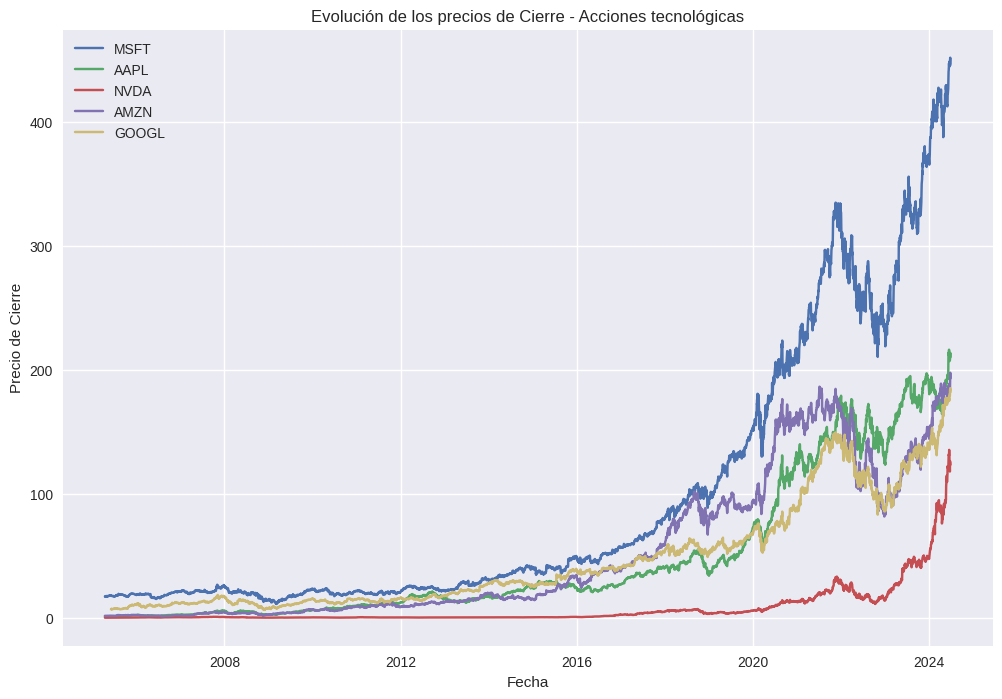

In [ ]:
#gráfico comparativo de los precios de cierre de las 5 acciones
plt.figure(figsize=(12,8))
for stock in stocks_tickers:
  plt.plot(tech_df.loc[stock]['Close'], label=stock)

plt.title('Evolución de los precios de Cierre - Acciones tecnológicas')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

###4.1.1. Gráficos univariados

In [ ]:
#definiendo los estilos de gráficos
sns.set_style("whitegrid", {'axes.facecolor': '.95'}), sns.set_context("notebook"), sns.set_palette("colorblind")
plt.style.use('seaborn-v0_8')

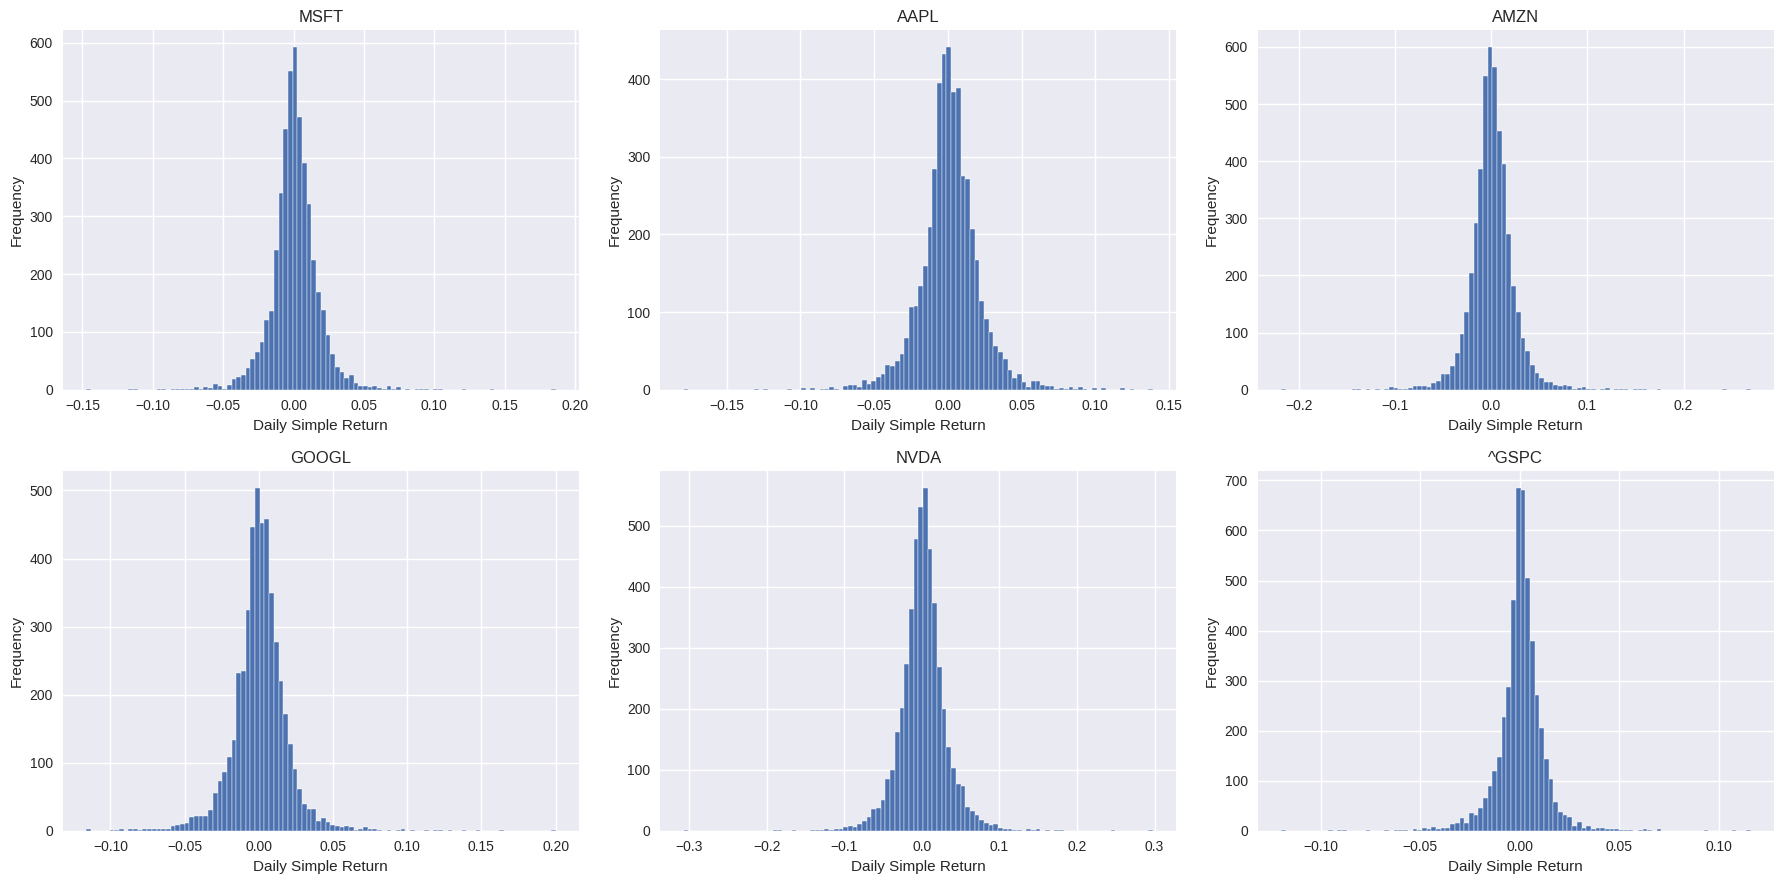

In [ ]:
#histogramas de distribución de los retornos diarios de MSFT, AAPL, AMZN, GOOGL y NVDA
fig, axs = plt.subplots(2, 3, figsize=(18, 9))

tickers = ['MSFT', 'AAPL', 'AMZN', 'GOOGL', 'NVDA', '^GSPC']

for i, stock in enumerate(tickers):
  row = i // 3
  col = i % 3
  axs[row, col].hist(tech_df.loc[stock]['Daily Simple Return'], bins=100)
  axs[row, col].set_title(stock)
  axs[row, col].set_xlabel('Daily Simple Return')
  axs[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

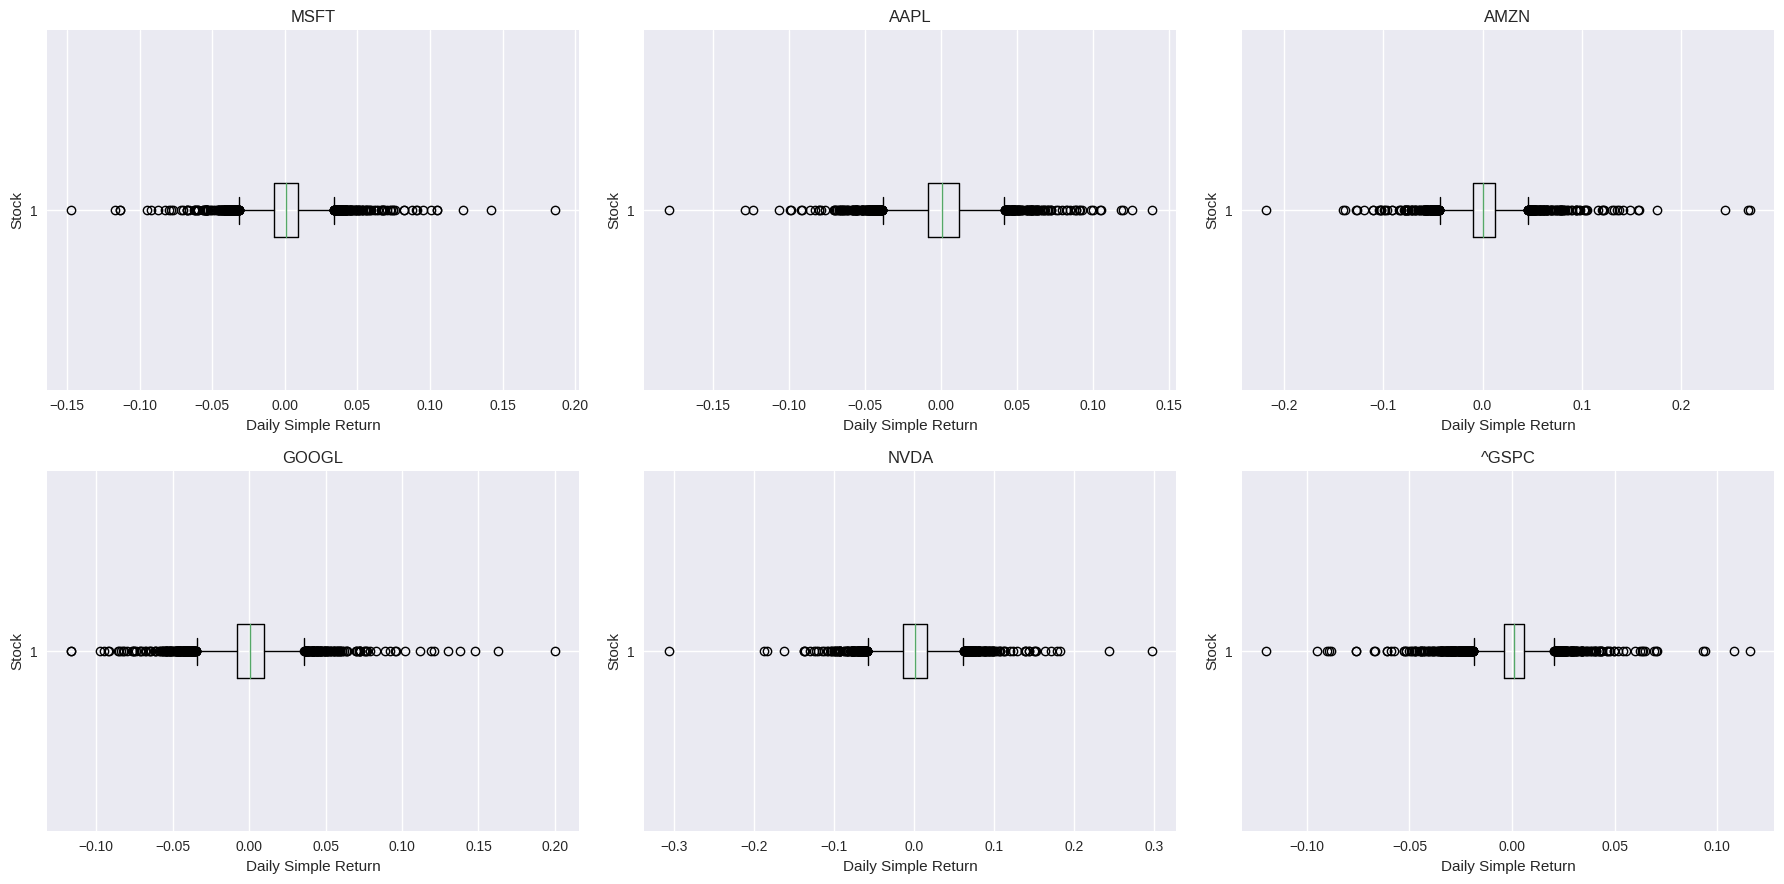

In [ ]:
#boxplot retornos diarios
fig, axs = plt.subplots(2, 3, figsize=(18,9))

for i, stock in enumerate(tickers):
  row = i // 3
  col = i % 3
  axs[row, col].boxplot(tech_df.loc[stock]['Daily Simple Return'].dropna(), vert=False)
  axs[row, col].set_title(stock)
  axs[row, col].set_ylabel('Stock')
  axs[row, col].set_xlabel('Daily Simple Return')

plt.tight_layout()

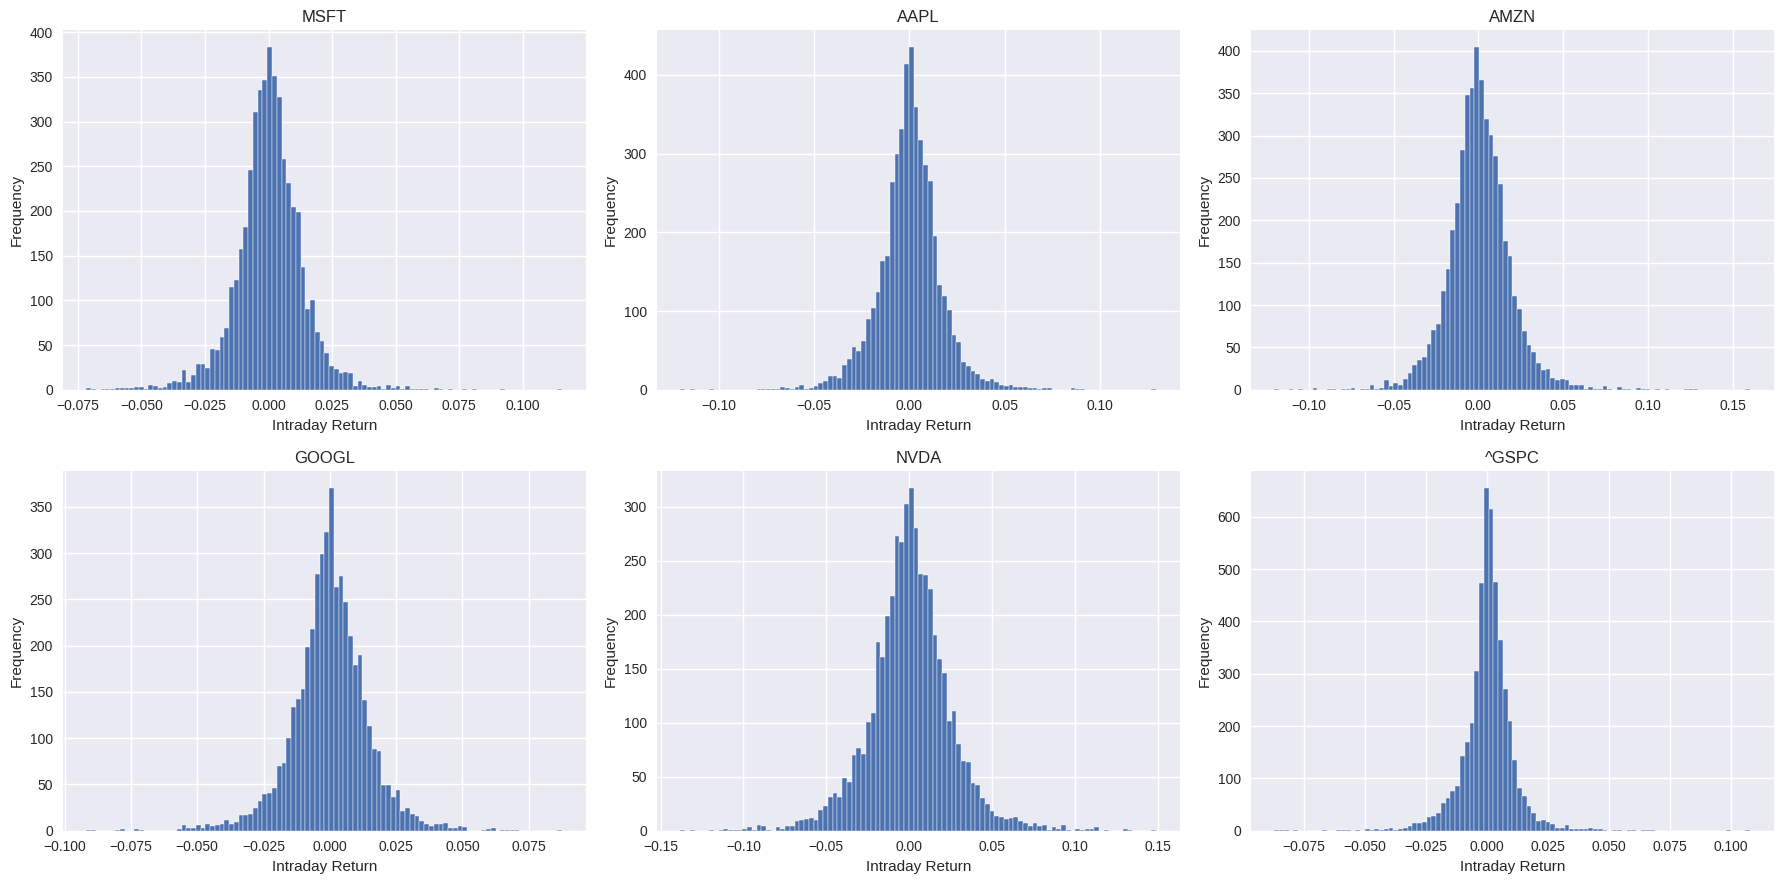

In [ ]:
#histogramas de distribución de los retornos intradiarios de MSFT, AAPL, AMZN, GOOGL y NVDA
fig, axs = plt.subplots(2, 3, figsize=(18, 9))

for i, stock in enumerate(tickers):
  row = i // 3
  col = i % 3
  axs[row, col].hist(tech_df.loc[stock]['Intraday Return'], bins=100)
  axs[row, col].set_title(stock)
  axs[row, col].set_xlabel('Intraday Return')
  axs[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

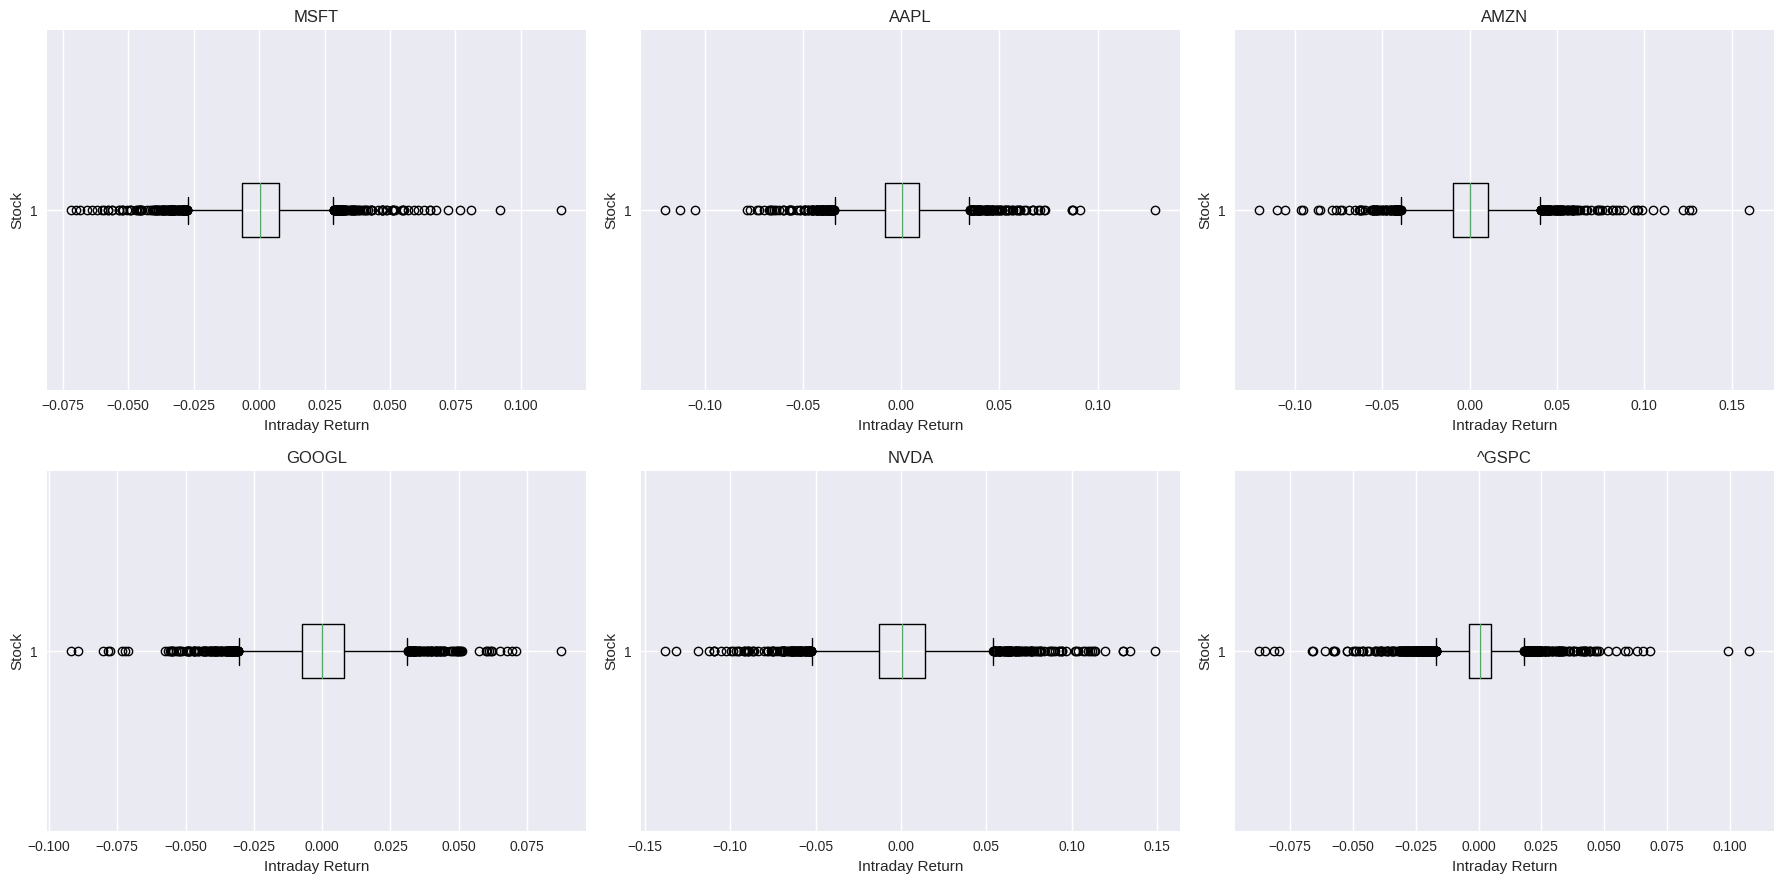

In [ ]:
# boxplot retornos intradiarios
fig, axs = plt.subplots(2,3, figsize=(18,9))

for i, stock in enumerate(tickers):
  row = i // 3
  col = i % 3
  axs[row, col].boxplot(tech_df.loc[stock]['Intraday Return'].dropna(), vert=False)
  axs[row, col].set_title(stock)
  axs[row, col].set_ylabel('Stock')
  axs[row, col].set_xlabel('Intraday Return')

plt.tight_layout()


No se observa una gran diferencia entre la distribución de los retornos intradiarios respecto a los diarios, por lo que para simplificar y acotar el análisis se continuará solo con éstos últimos.

###4.1.2. Gráficos bivariados

In [ ]:
#creando un dataFrame que solo contenga los retornos simples diarios organizados en columnas por activo
returns_dict = {}

for stock in stocks:
  returns_dict[stock] = tech_df.loc[stock]['Daily Simple Return']

returns_dict.update({'^GSPC': tech_df.loc['^GSPC']['Daily Simple Return'], '^IXIC': tech_df.loc['^IXIC']['Daily Simple Return']})

returns_df = pd.DataFrame(returns_dict)
returns_df.dropna(inplace=True)
returns_df

,MSFT,AAPL,NVDA,AMZN,GOOGL,^GSPC,^IXIC
Date,,,,,,,
2005-06-03,-0.013959,-0.044956,-0.002470,-0.022521,-0.026537,-0.006867,-0.012570
2005-06-06,-0.002359,-0.008368,-0.009541,0.005058,0.038107,0.001246,0.002090
2005-06-07,0.005519,-0.036393,-0.024257,-0.011742,0.007493,-0.000209,-0.004143
2005-06-08,-0.004312,0.010399,-0.006950,-0.014710,-0.046261,-0.002163,-0.003377
2005-06-09,0.004331,0.019773,0.041974,0.010623,0.024145,0.005240,0.008121
...,...,...,...,...,...,...,...
2024-06-24,-0.004691,0.003133,-0.066840,-0.018564,-0.002282,-0.003065,-0.010884
2024-06-25,0.007327,0.004468,0.067564,0.004149,0.026839,0.003934,0.012621
2024-06-26,0.002683,0.019993,0.002459,0.039015,-0.000815,0.001572,0.004939


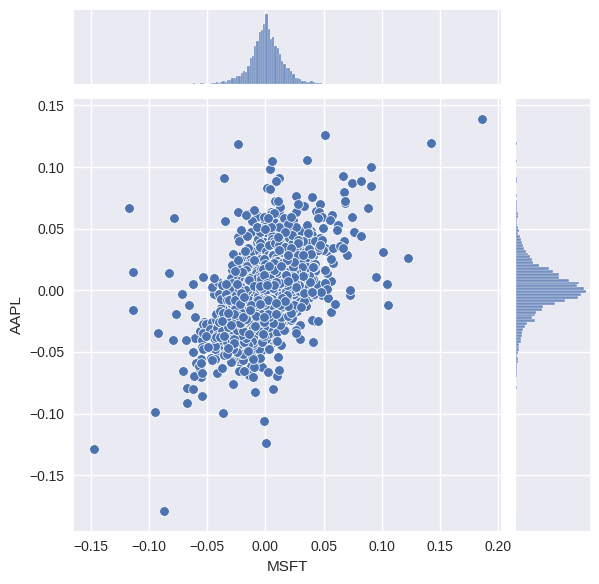

In [ ]:
#joinplot MSFT vs AAPL (principal competidora)
sns.jointplot(data=returns_df, x='MSFT', y='AAPL', kind='scatter')


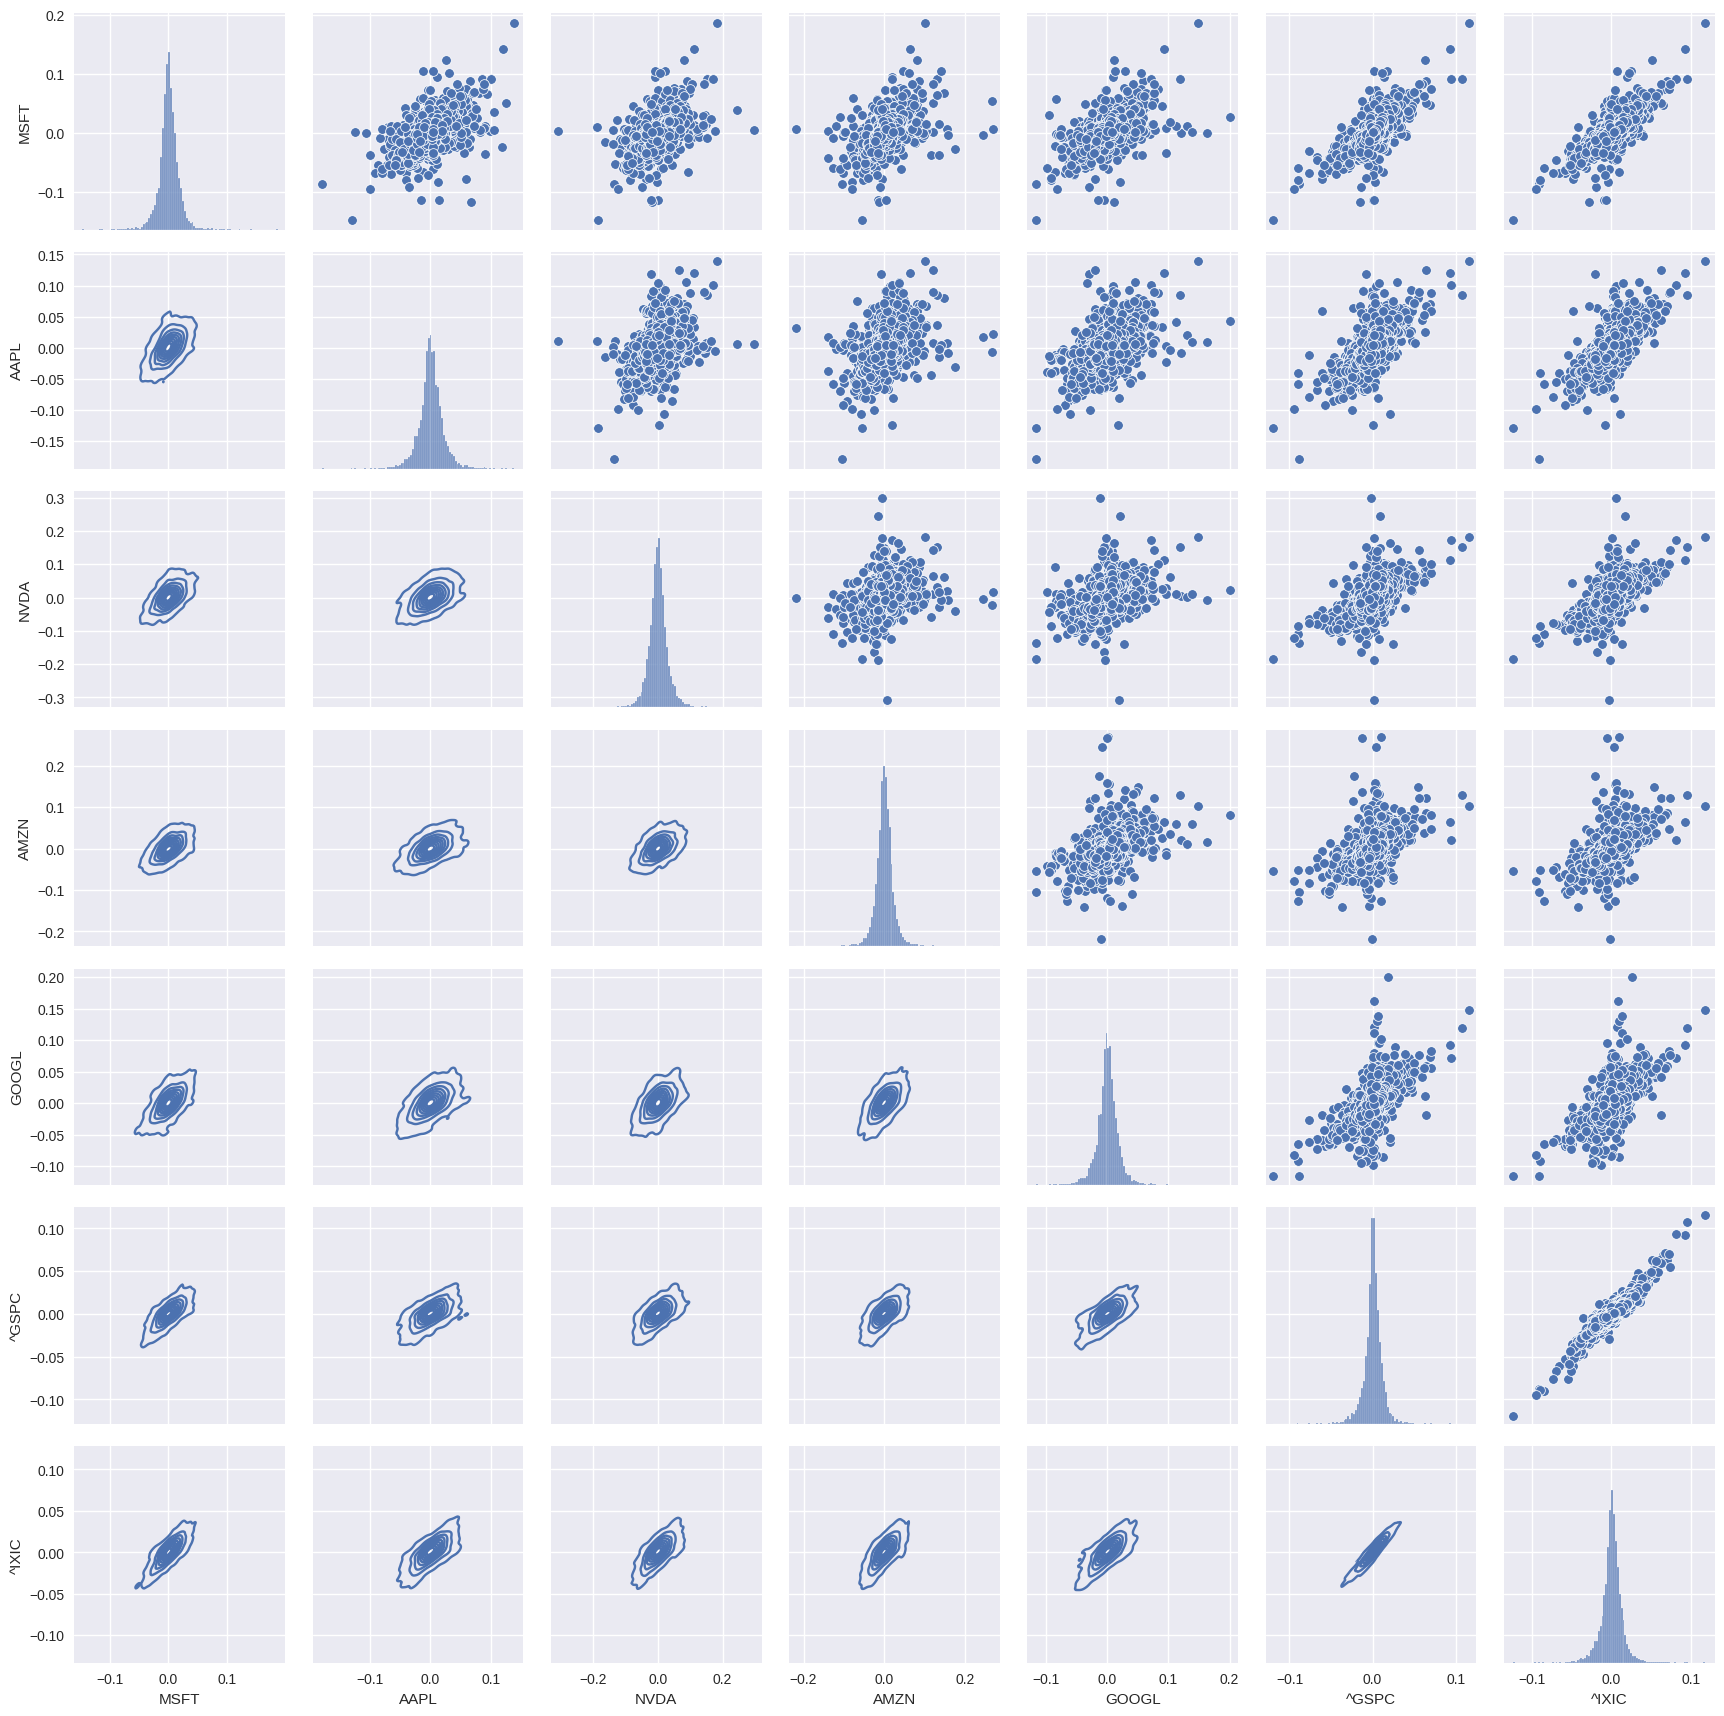

In [ ]:
#creando un PairGrid para comparar los retornos entre los activos de returns_df
returns_fig = sns.PairGrid(returns_df)
returns_fig.map_upper(sns.scatterplot)
returns_fig.map_lower(sns.kdeplot)
returns_fig.map_diag(sns.histplot, bins=100)


<Axes: >

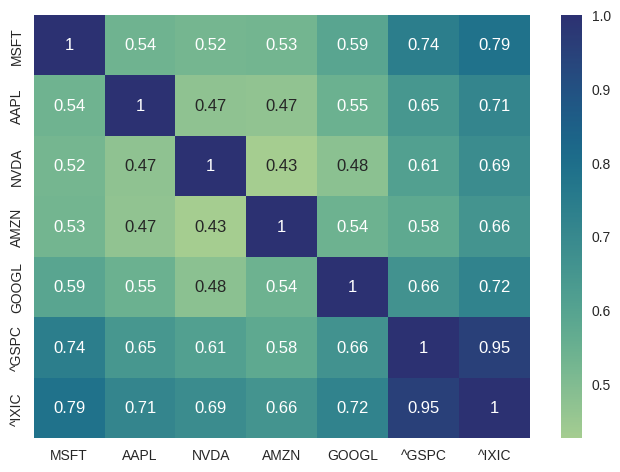

In [ ]:
#heatmap de correlaciones
returns_corr = returns_df.corr()
sns.heatmap(returns_corr, annot=True, cmap="crest")

**Insight**: Se observa que los retornos diarios de las acciones correlacionan positivamente entre sí, donde se destaca por ejemplo la correlación de MSFT vs GOOGL, con un 0,59 que resulta incluso mayor a la correlación con su competidor histórico AAPL.
A su vez, las acciones correlacionan en mayor medida con los principales índices, lo cual es esperable ya que ponderan considerablemente en los mismos por tratarse de los activos de mayor capitalización bursátil del mercado.

###4.1.3. Gráficos multivariados

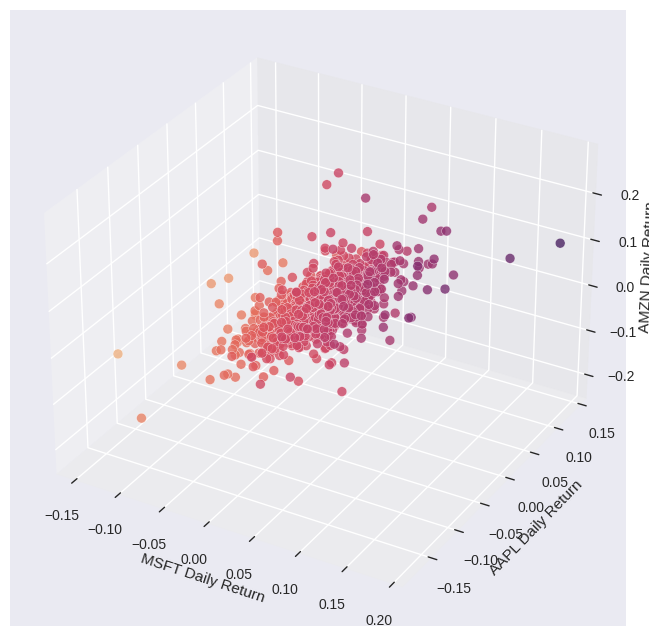

In [ ]:
#scatterplot 3D retornos diarios de MSFT, AAPL y AMZN
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(stocks['MSFT']['Daily Simple Return'], stocks['AAPL']['Daily Simple Return'], stocks['AMZN']['Daily Simple Return'], c=stocks['MSFT']['Daily Simple Return'], cmap='flare', s=50, alpha=0.8, edgecolors='w')

ax.set_xlabel('MSFT Daily Return')
ax.set_ylabel('AAPL Daily Return')
ax.set_zlabel('AMZN Daily Return')

plt.show()

##4.2 Análisis de los principales Índices

In [ ]:
#analizando los índices
indexes_dict = {}

for index in indexes:
  indexes_dict[index] = tech_df.loc[index]['Daily Simple Return']

indexes_df = pd.DataFrame(indexes_dict)
indexes_df.dropna(inplace=True)
indexes_df


,^GSPC,^IXIC,^VIX,^TNX
Date,,,,
2005-04-14,-0.010002,-0.014010,0.091660,-0.003658
2005-04-15,-0.016720,-0.019808,0.220922,-0.019963
2005-04-18,0.002941,0.002500,-0.066516,-0.005151
2005-04-19,0.005934,0.010162,-0.096618,-0.010826
2005-04-20,-0.013255,-0.009626,0.131016,0.001903
...,...,...,...,...
2024-06-24,-0.003065,-0.010884,0.009848,-0.002114
2024-06-25,0.003934,0.012621,-0.036759,-0.002354
2024-06-26,0.001572,0.004939,-0.022586,0.018405


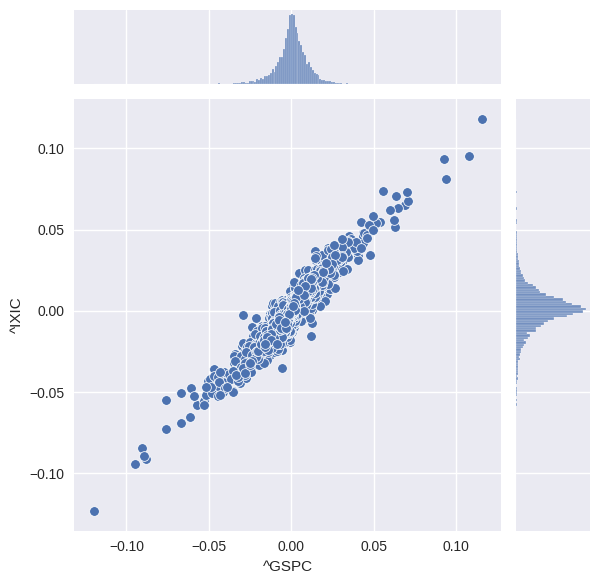

In [ ]:
#joinplot S&P500 vs NASDAQ Composite
sns.jointplot(data=indexes_df, x='^GSPC', y='^IXIC', kind='scatter')

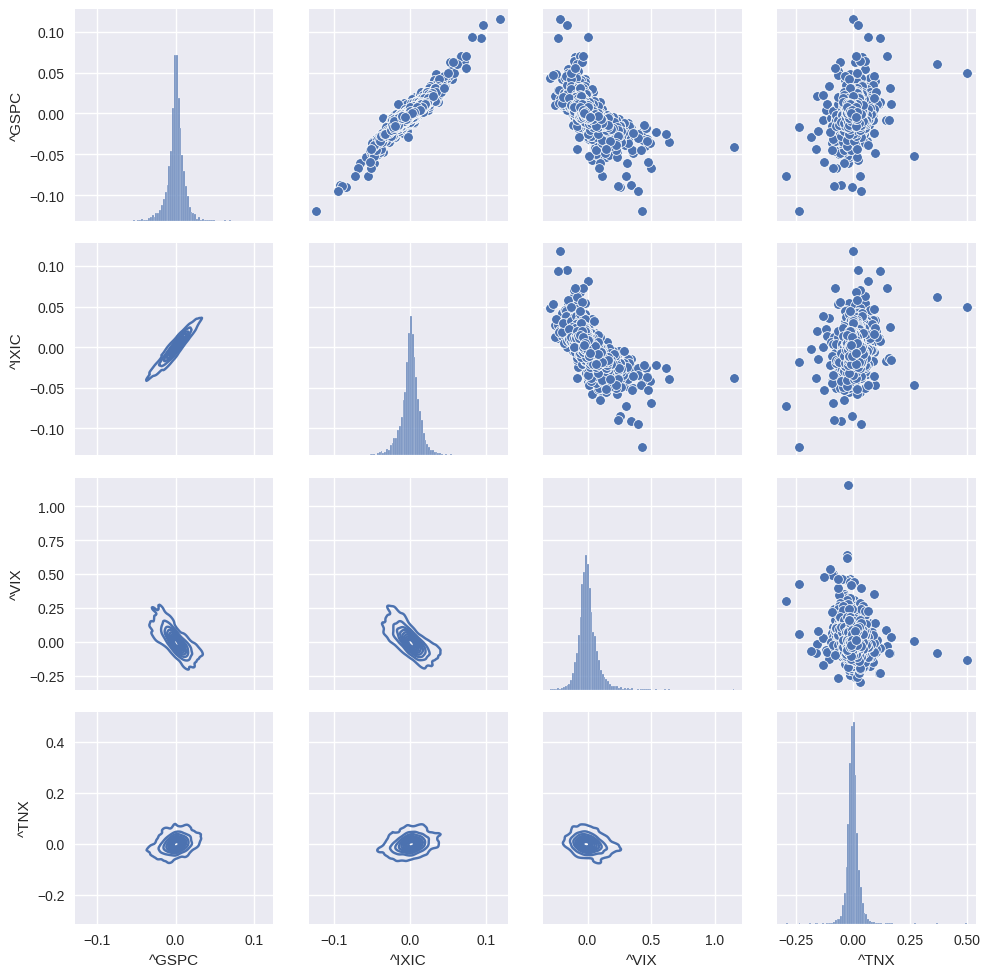

In [ ]:
#PairGrid
indexes_fig = sns.PairGrid(indexes_df)
indexes_fig.map_upper(sns.scatterplot)
indexes_fig.map_lower(sns.kdeplot)
indexes_fig.map_diag(sns.histplot, bins=100)

<Axes: >

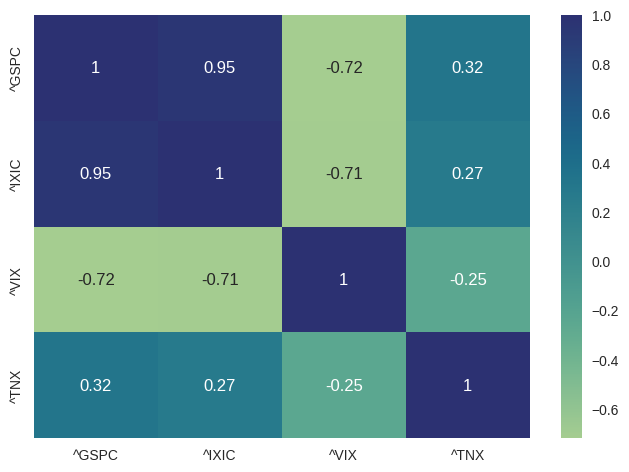

In [ ]:
#heatmap
indexes_corr = indexes_df.corr()
sns.heatmap(indexes_corr, annot=True, cmap="crest")

**Insight**: Se observa que, como se planteó en una de las preguntas inciales, las variaciones en el VIX correlacionan negativamente con el S&P500, es decir, un aumento en la volatilidad de las Opciones del índice a corto plazo impactan negativamente en los retornos diarios del mercado.
También se observa que los aumentos de tasa no afectan en gran medida a la evolución de los retornos diarios de los principales índices. Este punto merece un mejor análisis, ya que en general los cambios de tasa se realizan bajo mucha prudencia, con variaciones suaves y con objetivos de política monetaria a mediano/largo plazo, tales como el control de la inflación, por lo que el impacto en la capitalización total de las acciones puede no apreciarse en las variaciones diarias.

##4.3. Riesgo vs Retorno

In [ ]:
risk_ret_dict = {}

for asset in returns_df:
  risk_ret_dict[asset] = [returns_df[asset].mean(), returns_df[asset].std()]

risk_ret_df = pd.DataFrame(risk_ret_dict, index=['Retorno Medio', 'Volatilidad']).T
risk_ret_df

,Retorno Medio,Volatilidad
MSFT,0.000818,0.017317
AAPL,0.001280,0.020232
NVDA,0.001792,0.030637
AMZN,0.001258,0.024046
GOOGL,0.000850,0.018856
^GSPC,0.000390,0.012233
^IXIC,0.000539,0.013699


<ipython-input-202-d1cbbe12e2d9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(risk_ret_df.index[i], (risk_ret_df['Volatilidad'][i], risk_ret_df['Retorno Medio'][i]))


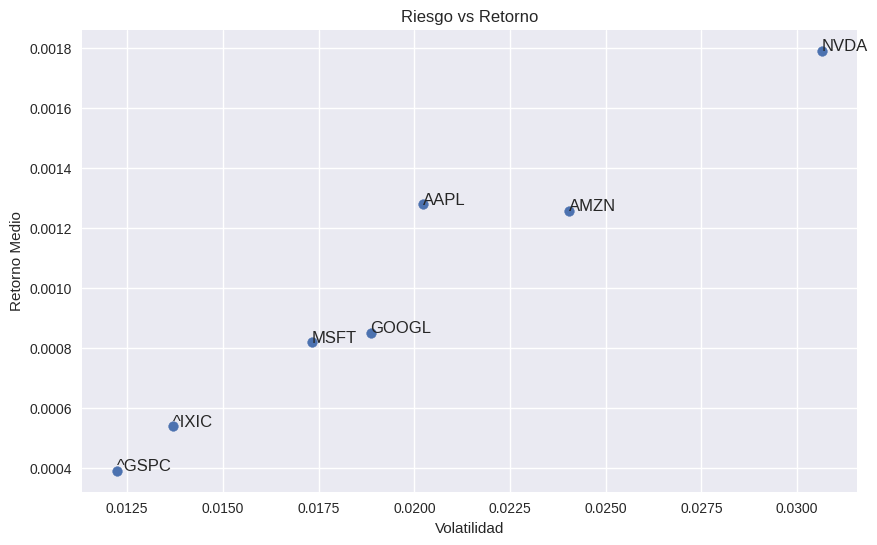

In [ ]:
#scatterplot riesgo vs retorno
plt.figure(figsize=(10,6))
plt.scatter(risk_ret_df['Volatilidad'], risk_ret_df['Retorno Medio'])
plt.xlabel('Volatilidad')
plt.ylabel('Retorno Medio')
plt.title('Riesgo vs Retorno')

for i in range(len(risk_ret_df)):
  plt.annotate(risk_ret_df.index[i], (risk_ret_df['Volatilidad'][i], risk_ret_df['Retorno Medio'][i]))

plt.show()

**Insight**: Se observa una relación proporcional bastante lineal entre los retornos medios esperados y la volatilidad media de cada activo, en otras palabras, es esperable que en promedio un mayor rendimiento diario conlleve un mayor riesgo asumido frente a las variaciones de precio (positivas o negativas) del activo.

#5. Preparación del modelo
---
Se plantea predecir los retornos diarios de una acción en particular, en este caso Microsoft, por lo que se procura focalizar la selección de variables para este objetivo.

##5.1. Selección de variables

###5.1.1. Análisis de correlación

<Axes: >

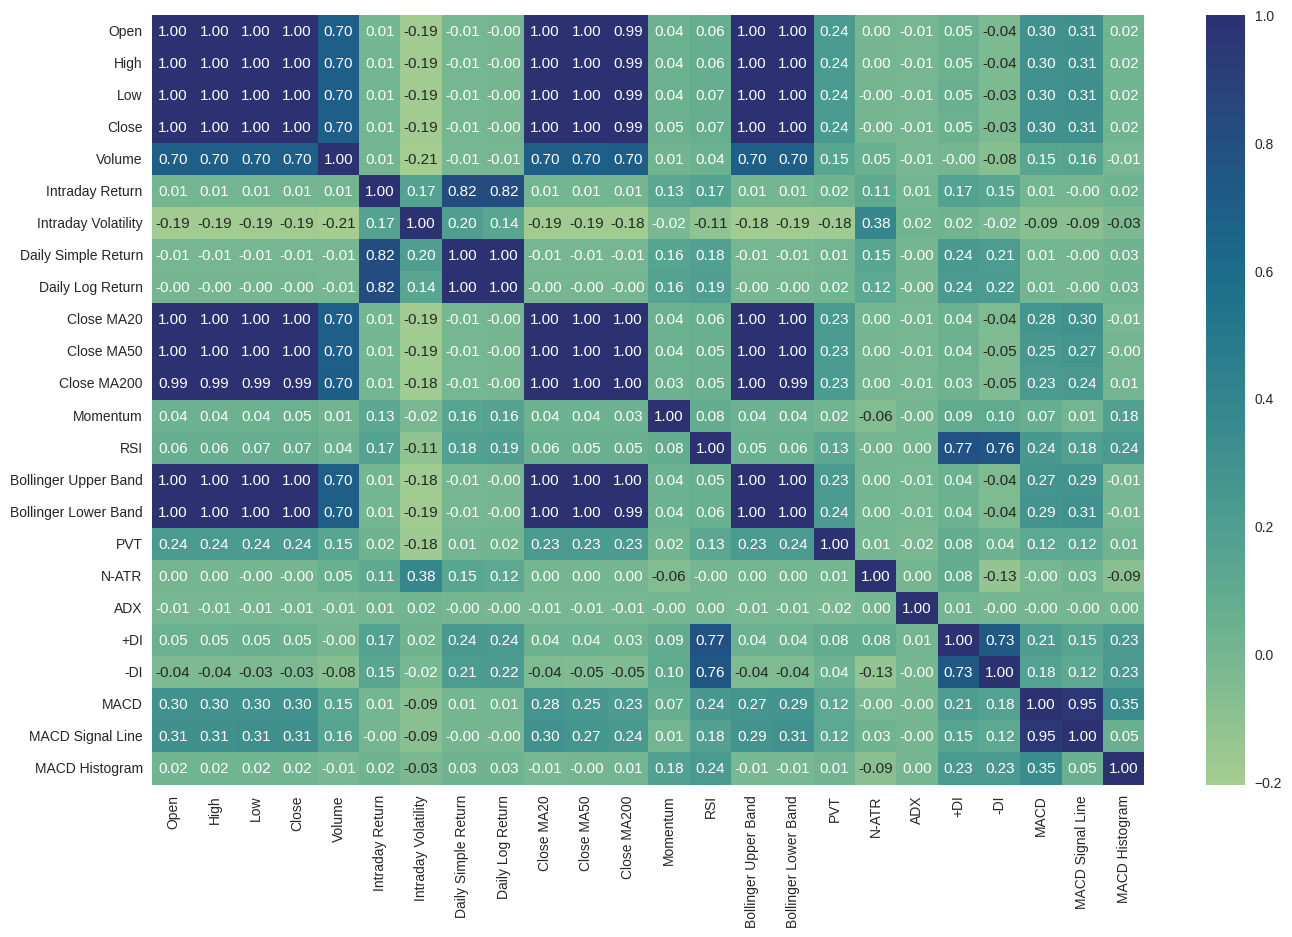

In [ ]:
#matriz de correlación de tech_df completa
plt.figure(figsize=(16, 10))
corr_matrix = tech_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="crest",  fmt=".2f", annot_kws={"size": 11})

<Axes: >

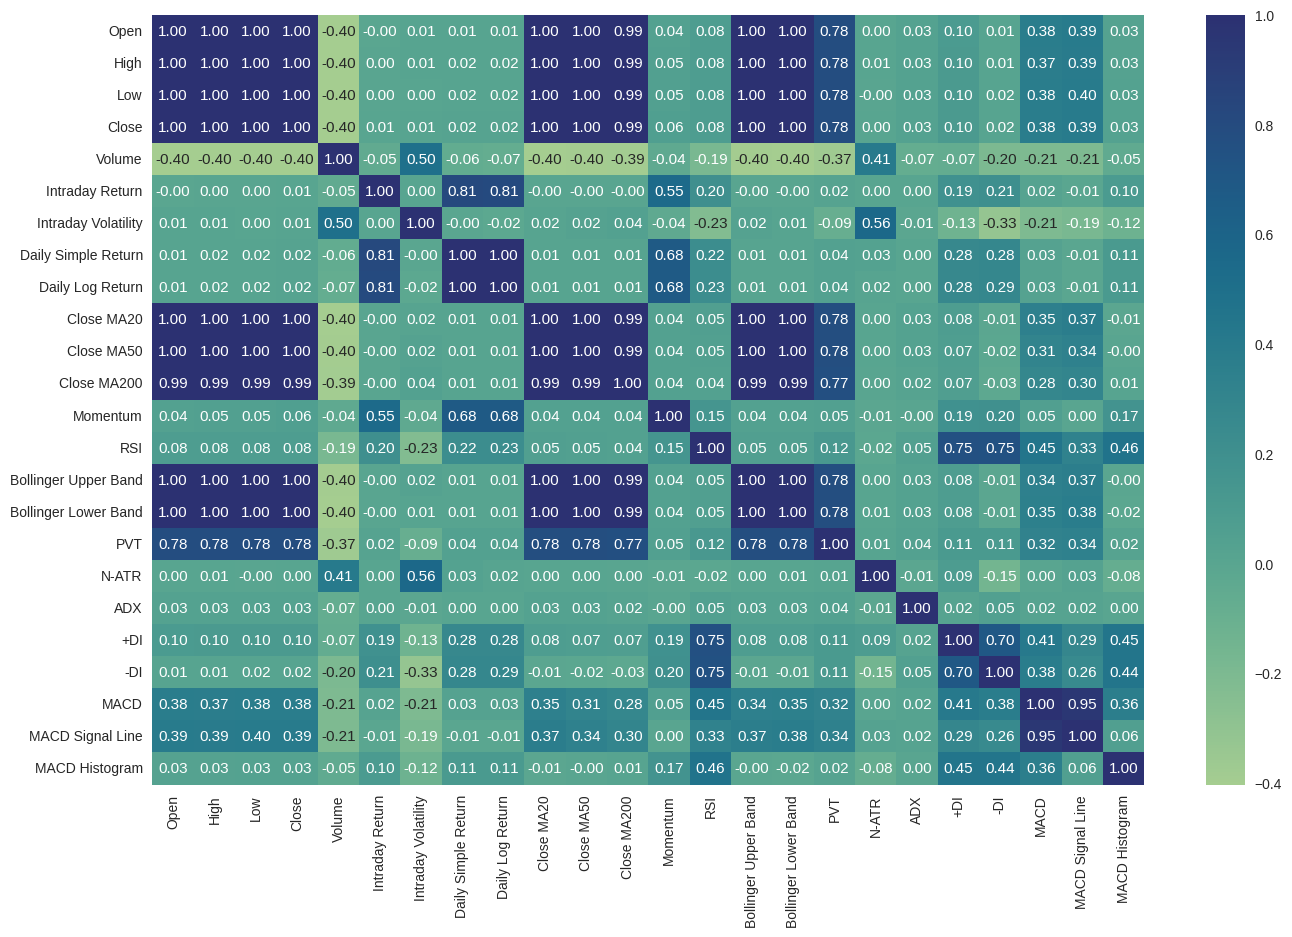

In [ ]:
#matriz de correlación para MSFT
MSFT = tech_df.loc['MSFT'].copy()
plt.figure(figsize=(16, 10))
corr_matrix = MSFT.corr()
sns.heatmap(corr_matrix, annot=True, cmap="crest",  fmt=".2f", annot_kws={"size": 11})

Analizando las correlaciones de ambas matrices y con la idea de predecir la variable objetivo Daily Simple Return de MSFT se decide:

- Dropear las siguientes columnas:
 - *Dividends*, *Stocks Splits* y *Symbol* por no ser relevantes para la predicción.
 - *Daily Log Return* por ser redundante en la información brindada en comparación a *Daily Simple Return*.
 - *Close MA20*, *Close MA50*, *Close MA200*, *Bollinger Upper Band*, *Bollinger Lower Band*, *PVT*, *ADX*, *MACD*, *MACD Signal Line* y *MACD Histogram* por no correlacionar significativamente con los retornos diarios (variable objetivo).

- Mantener las columnas de *Open*, *High*, *Low*, *Close* y *Volume* por considerarse esenciales, ya que brindan información fundamental de base sobre el precio de los activos.

- Añadir las columnas de *Intraday Return*, *Intraday Volatility* y *Daily Simple Return* del resto de los activos como posibles variables predictoras.

In [ ]:
MSFT

,Open,High,Low,Close,Volume,Intraday Return,Intraday Volatility,Daily Simple Return,Daily Log Return,Close MA20,...,Bollinger Upper Band,Bollinger Lower Band,PVT,N-ATR,ADX,+DI,-DI,MACD,MACD Signal Line,MACD Histogram
Date,,,,,,,,,,,,,,,,,,,,,
2005-04-14,17.444144,17.534817,17.318596,17.325571,66754400,-0.006797,0.012395,-0.007987,-0.008019,17.076222,...,17.656223,16.496222,2.719383e+06,0.864542,17.316718,28.724661,-16.316482,-0.002662,-0.092557,0.089895
2005-04-15,17.144233,17.367428,17.025660,17.060534,100251600,-0.004882,0.019935,-0.015297,-0.015416,17.073433,...,17.653157,16.493708,1.185786e+06,1.314179,-152.894575,23.885790,-28.006630,-0.020653,-0.078176,0.057523
2005-04-18,17.053556,17.325575,17.018681,17.193052,75766400,0.008180,0.017996,0.007768,0.007738,17.085290,...,17.664594,16.505985,1.774307e+06,1.175577,-286.830837,20.336298,-24.182710,-0.023942,-0.067329,0.043387
2005-04-19,17.234899,17.297673,17.053554,17.179100,65956200,-0.003238,0.014164,-0.000812,-0.000812,17.100286,...,17.672611,16.527961,1.720783e+06,0.921049,-402.908930,17.895504,-21.280263,-0.027359,-0.059335,0.031976
2005-04-20,17.200027,17.227927,16.948931,16.962881,91923500,-0.013788,0.016221,-0.012586,-0.012666,17.111795,...,17.661820,16.561770,5.638187e+05,1.012662,-413.724841,15.450180,-23.496556,-0.046973,-0.056863,0.009890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,448.990736,451.935440,445.606851,446.864594,15913700,-0.004735,0.014095,-0.004691,-0.004702,431.474307,...,456.161825,406.786790,3.152346e+07,1.012202,714.335772,38.929850,-14.379645,8.139496,6.529592,1.609904
2024-06-25,447.443517,450.607827,445.946216,450.138672,16747500,0.006023,0.010418,0.007327,0.007300,432.511937,...,458.538092,406.485782,3.164616e+07,0.763788,648.043643,35.031247,-12.939605,8.372490,6.898172,1.474318
2024-06-26,448.192178,452.783908,447.383638,451.346497,16507000,0.007038,0.012049,0.002683,0.002680,433.601973,...,460.900103,406.303843,3.169045e+07,0.912531,587.525195,35.652765,-11.411987,8.555973,7.229732,1.326241


In [ ]:
MSFT.drop(columns=['Daily Log Return', 'Close MA20', 'Close MA50', 'Close MA200', 'Bollinger Upper Band', 'Bollinger Lower Band', 'PVT', 'ADX', 'MACD', 'MACD Signal Line', 'MACD Histogram'], inplace=True)
MSFT

,Open,High,Low,Close,Volume,Intraday Return,Intraday Volatility,Daily Simple Return,Momentum,RSI,N-ATR,+DI,-DI
Date,,,,,,,,,,,,,
2005-04-14,17.444144,17.534817,17.318596,17.325571,66754400,-0.006797,0.012395,-0.007987,-0.139498,60.526532,0.864542,28.724661,-16.316482
2005-04-15,17.144233,17.367428,17.025660,17.060534,100251600,-0.004882,0.019935,-0.015297,-0.265038,54.392210,1.314179,23.885790,-28.006630
2005-04-18,17.053556,17.325575,17.018681,17.193052,75766400,0.008180,0.017996,0.007768,0.132519,62.717854,1.175577,20.336298,-24.182710
2005-04-19,17.234899,17.297673,17.053554,17.179100,65956200,-0.003238,0.014164,-0.000812,-0.013952,58.868048,0.921049,17.895504,-21.280263
2005-04-20,17.200027,17.227927,16.948931,16.962881,91923500,-0.013788,0.016221,-0.012586,-0.216219,52.542466,1.012662,15.450180,-23.496556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,448.990736,451.935440,445.606851,446.864594,15913700,-0.004735,0.014095,-0.004691,-2.106171,87.902509,1.012202,38.929850,-14.379645
2024-06-25,447.443517,450.607827,445.946216,450.138672,16747500,0.006023,0.010418,0.007327,3.274078,88.095402,0.763788,35.031247,-12.939605
2024-06-26,448.192178,452.783908,447.383638,451.346497,16507000,0.007038,0.012049,0.002683,1.207825,86.043724,0.912531,35.652765,-11.411987


In [ ]:
tickers = ['AAPL', 'AMZN', 'GOOGL', 'NVDA', '^GSPC', '^IXIC', '^VIX', '^TNX']

for ticker in tickers:
  MSFT[f'{ticker}_Intraday Return'] = tech_df.loc[ticker]['Intraday Return']
  MSFT[f'{ticker}_Intraday Volatility'] = tech_df.loc[ticker]['Intraday Volatility']
  MSFT[f'{ticker}_Daily Simple Return'] = tech_df.loc[ticker]['Daily Simple Return']

MSFT

,Open,High,Low,Close,Volume,Intraday Return,Intraday Volatility,Daily Simple Return,Momentum,RSI,...,^GSPC_Daily Simple Return,^IXIC_Intraday Return,^IXIC_Intraday Volatility,^IXIC_Daily Simple Return,^VIX_Intraday Return,^VIX_Intraday Volatility,^VIX_Daily Simple Return,^TNX_Intraday Return,^TNX_Intraday Volatility,^TNX_Daily Simple Return
Date,,,,,,,,,,,,,,,,,,,,,
2005-04-14,17.444144,17.534817,17.318596,17.325571,66754400,-0.006797,0.012395,-0.007987,-0.139498,60.526532,...,-0.010002,-0.013915,0.014609,-0.014010,0.084328,0.144030,0.091660,0.001149,0.008040,-0.003658
2005-04-15,17.144233,17.367428,17.025660,17.060534,100251600,-0.004882,0.019935,-0.015297,-0.265038,54.392210,...,-0.016720,-0.012835,0.017300,-0.019808,0.189008,0.223861,0.220922,-0.008128,0.014631,-0.019963
2005-04-18,17.053556,17.325575,17.018681,17.193052,75766400,0.008180,0.017996,0.007768,0.132519,62.717854,...,0.002941,0.003404,0.009137,0.002500,-0.096563,0.118931,-0.066516,0.001886,0.011318,-0.005151
2005-04-19,17.234899,17.297673,17.053554,17.179100,65956200,-0.003238,0.014164,-0.000812,-0.013952,58.868048,...,0.005934,0.004961,0.007832,0.010162,-0.020942,0.075916,-0.096618,-0.018220,0.021957,-0.010826
2005-04-20,17.200027,17.227927,16.948931,16.962881,91923500,-0.013788,0.016221,-0.012586,-0.216219,52.542466,...,-0.013255,-0.015880,0.017098,-0.009626,0.138627,0.183715,0.131016,-0.004256,0.022227,0.001903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,448.990736,451.935440,445.606851,446.864594,15913700,-0.004735,0.014095,-0.004691,-2.106171,87.902509,...,-0.003065,-0.008131,0.013384,-0.010884,-0.037545,0.052708,0.009848,-0.006316,0.006784,-0.002114
2024-06-25,447.443517,450.607827,445.946216,450.138672,16747500,0.006023,0.010418,0.007327,3.274078,88.095402,...,0.003934,0.008280,0.010682,0.012621,-0.047478,0.050445,-0.036759,0.004980,0.011382,-0.002354
2024-06-26,448.192178,452.783908,447.383638,451.346497,16507000,0.007038,0.012049,0.002683,1.207825,86.043724,...,0.001572,0.006096,0.007147,0.004939,-0.020297,0.067916,-0.022586,0.007235,0.009102,0.018405


In [ ]:
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4835 entries, 2005-04-14 to 2024-06-28
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Open                       4835 non-null   float64
 1   High                       4835 non-null   float64
 2   Low                        4835 non-null   float64
 3   Close                      4835 non-null   float64
 4   Volume                     4835 non-null   int64  
 5   Intraday Return            4835 non-null   float64
 6   Intraday Volatility        4835 non-null   float64
 7   Daily Simple Return        4835 non-null   float64
 8   Momentum                   4835 non-null   float64
 9   RSI                        4835 non-null   float64
 10  N-ATR                      4835 non-null   float64
 11  +DI                        4835 non-null   float64
 12  -DI                        4835 non-null   float64
 13  AAPL_Intraday Return       483

In [ ]:
MSFT.dropna(inplace=True)
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4795 entries, 2005-06-03 to 2024-06-28
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Open                       4795 non-null   float64
 1   High                       4795 non-null   float64
 2   Low                        4795 non-null   float64
 3   Close                      4795 non-null   float64
 4   Volume                     4795 non-null   int64  
 5   Intraday Return            4795 non-null   float64
 6   Intraday Volatility        4795 non-null   float64
 7   Daily Simple Return        4795 non-null   float64
 8   Momentum                   4795 non-null   float64
 9   RSI                        4795 non-null   float64
 10  N-ATR                      4795 non-null   float64
 11  +DI                        4795 non-null   float64
 12  -DI                        4795 non-null   float64
 13  AAPL_Intraday Return       479

<Axes: >

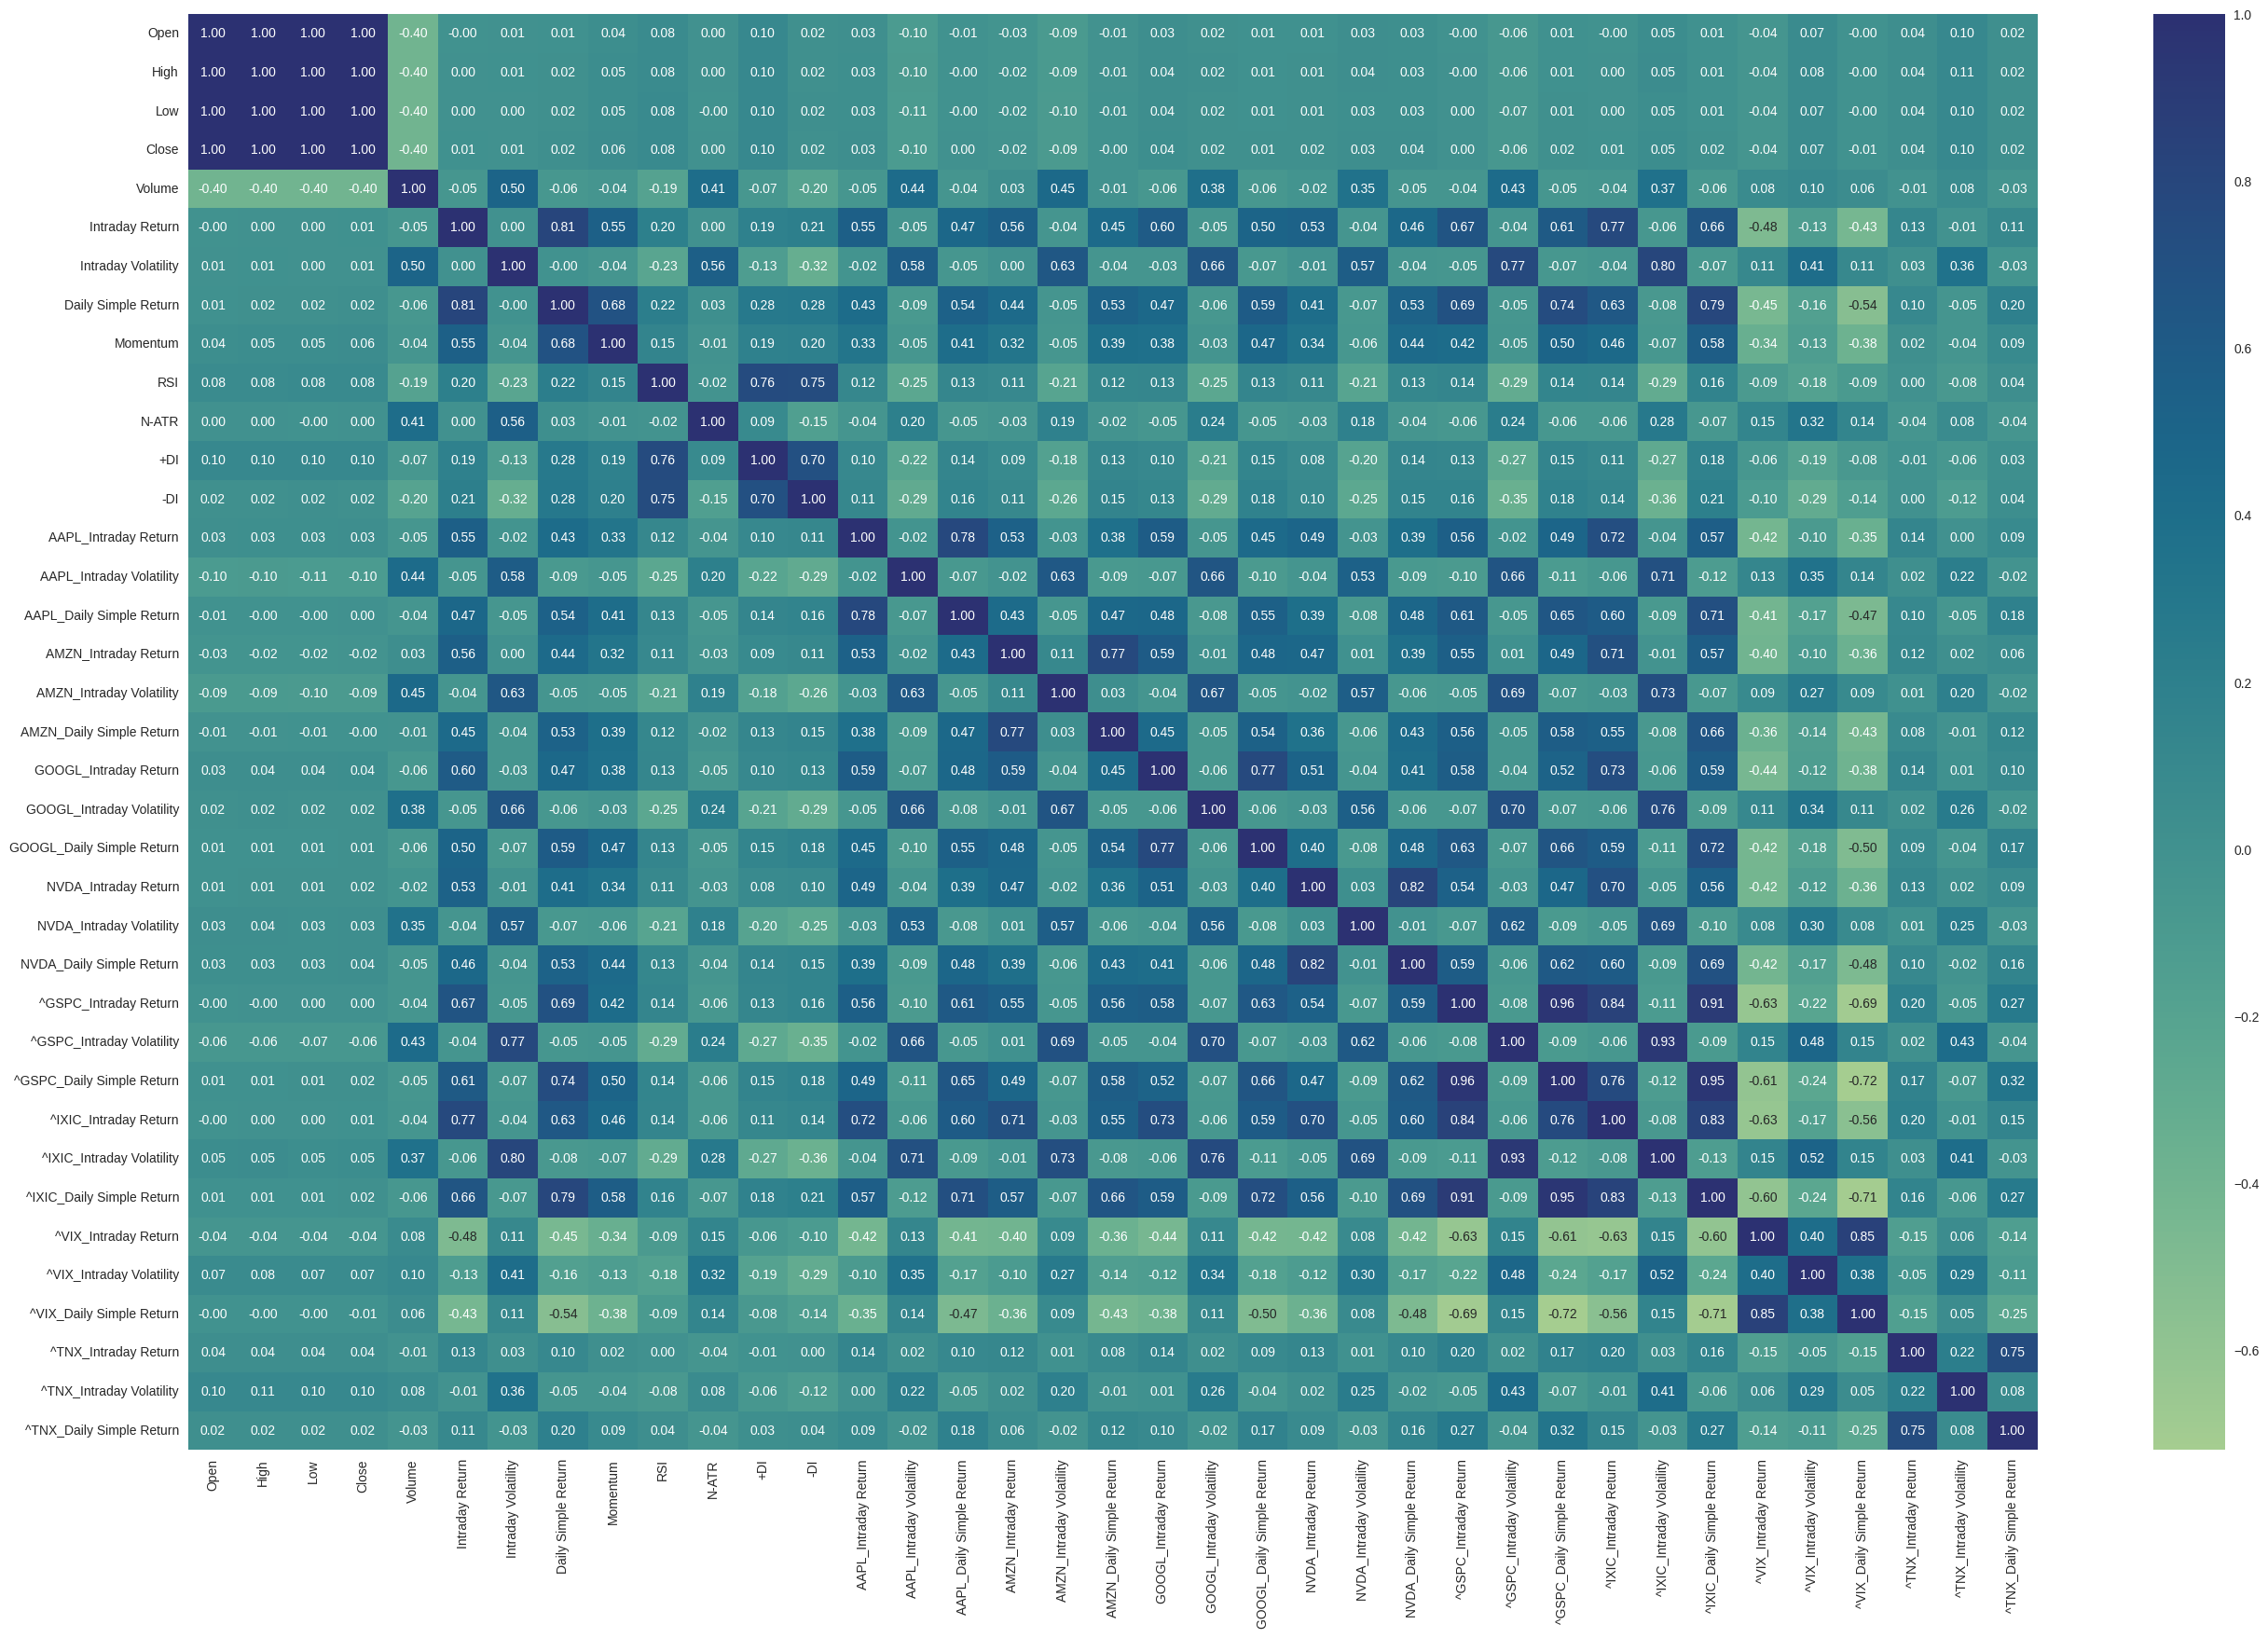

In [ ]:
#nueva matriz de correlación para MSFT
plt.figure(figsize=(32, 20))
corr_matrix = MSFT.corr()
sns.heatmap(corr_matrix, annot=True, cmap="crest",  fmt=".2f", annot_kws={"size": 10})

###5.1.2. Método de filtrado

Se utiliza el método **SelectKBest** acompañado de la función f_regression para seleccionar las características más relevantes con respecto a la variable objetivo.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

X = MSFT.drop(columns=['Daily Simple Return'])
y = MSFT['Daily Simple Return']

selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)
print(selector.get_support(indices=True))
SelectKBest_columns = X.columns[selector.get_support(indices=True)]
print(SelectKBest_columns)

[ 5  7 14 17 20 24 26 27 29 32]
Index(['Intraday Return', 'Momentum', 'AAPL_Daily Simple Return',
       'AMZN_Daily Simple Return', 'GOOGL_Daily Simple Return',
       '^GSPC_Intraday Return', '^GSPC_Daily Simple Return',
       '^IXIC_Intraday Return', '^IXIC_Daily Simple Return',
       '^VIX_Daily Simple Return'],
      dtype='object')


###5.1.3. Método de Envoltura
Se utiliza el método **Recursive Feature Elimination (RFE)** para evaluar la importancia de las características en conjunto con el modelo predictivo de Regresión Lineal.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
X_rfe = rfe.fit_transform(X, y)
print(rfe.support_)
rfe_columns = X.columns[rfe.support_]
print(rfe_columns)

[False False False False False  True  True False False False False False
  True  True  True False False False False False False False False False
  True  True  True  True False  True False False False False False False]
Index(['Intraday Return', 'Intraday Volatility', 'AAPL_Intraday Return',
       'AAPL_Intraday Volatility', 'AAPL_Daily Simple Return',
       '^GSPC_Intraday Return', '^GSPC_Intraday Volatility',
       '^GSPC_Daily Simple Return', '^IXIC_Intraday Return',
       '^IXIC_Daily Simple Return'],
      dtype='object')


###5.1.4. Método Integrado
Se utiliza un modelo de regresión de **Lasso** que penaliza las características menos importantes, eliminándolas efectivamente del modelo.

In [ ]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.01)
model.fit(X, y)
print(model.coef_)
lasso_columns = X.columns[model.coef_ != 0]
print(lasso_columns)

[-4.11062788e-06 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -2.24064395e-11  0.00000000e+00  0.00000000e+00  2.94724176e-03
  0.00000000e+00  0.00000000e+00  1.56085087e-04  1.34607512e-04
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00]
Index(['Open', 'Volume', 'Momentum', '+DI', '-DI'], dtype='object')


In [ ]:
#selección final en base a las columnas obtenidas
final_columns = SelectKBest_columns.intersection(rfe_columns).tolist()
final_columns.extend((lasso_columns).tolist())
final_columns

['Intraday Return',
 'AAPL_Daily Simple Return',
 '^GSPC_Intraday Return',
 '^GSPC_Daily Simple Return',
 '^IXIC_Intraday Return',
 '^IXIC_Daily Simple Return',
 'Open',
 'Volume',
 'Momentum',
 '+DI',
 '-DI']

Las columnas obtenidas por los métodos de SelectKBest y RFE fueron similares por lo que se decide utilizar una intersección, no obstante, las obtenidas por el método de Lasso eran pocas y diferentes por lo que se opta por añadirlas.
De esta manera se obtiene una selección final de 11 variables predictoras para el modelo.


#6 Entrenamiento de los modelos
---
Se entrenan y comparan 3 modelos de aprendizaje supervisado:
 - Regresión Lineal
 - Árbol de Decisión
 - Bosque Aleatorio

In [ ]:
#importando librerías necesarias
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [ ]:
#Deifnir variables: predictoras X, objetivo y
X = MSFT[final_columns]
y = MSFT['Daily Simple Return']

In [ ]:
#dividir los conjuntos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##6.1. Regresión Lineal

In [ ]:
#crear el modelo
model = LinearRegression()

In [ ]:
#validación cruzada del modelo
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("MSE scores para cada conjunto: ", -scores)
print("Media MSE: ", -scores.mean())
print("Desviación Estándar MSE: ", scores.std())

MSE scores para cada conjunto:  [4.50154536e-05 5.24491862e-05 2.21374157e-05 3.49799924e-05
 7.17055608e-05]
Media MSE:  4.525752173922078e-05
Desviación Estándar MSE:  1.668199218032642e-05


In [ ]:
#entrenar el modelo
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
#realizar predicciones
y_pred = model.predict(X_test)

In [ ]:
#evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Error cuadrático medio:", mse)
print("Coeficiente de determinación (R^2):", r2)

Error cuadrático medio: 3.286942627264789e-05
Coeficiente de determinación (R^2): 0.8823771983096027


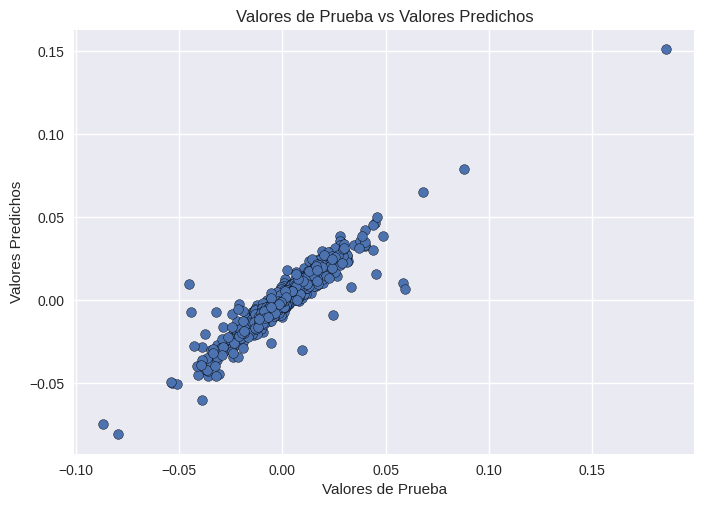

In [ ]:
#comparar valores de prueba y valores predichos
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.xlabel("Valores de Prueba")
plt.ylabel("Valores Predichos")
plt.title("Valores de Prueba vs Valores Predichos")
plt.show()

**Conclusión**: Se observa que el modelo alcanza un Coeficiente de determinación R^2 de 0.8823, lo que significa que es capaz de explicar el 88,23% de la variabilidad de los retornos diarios de MSFT en función de las variables predictoras seleccionadas, lo cual es un buen indicador de la capacidad predictiva del modelo.

Se entiende que los resultados son confiables ya que el Error Cuadrático Medio MSE obtenido se encuentra dentro del rango esperado según la validación cruzada. El valor de 3.28e-05 se encuentra dentro del intervalo resultante de acuerdo a la media de 4.52e-05 +- 1.66e-05 obtenida con la validación cruzada, es decir, entre 2.86e-05 y 6.18e-05 aproximadamente. El error está bien alineado con lo que se podría esperar, lo que sugiere que el modelo generaliza bien y los resultados son consistentes.

##6.2. Árbol de Decisión

In [ ]:
#crear el modelo
model = DecisionTreeRegressor(random_state=42)

In [ ]:
#validación cruzada del modelo
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("MSE scores para cada conjunto: ", -scores)
print("Media MSE: ", -scores.mean())
print("Desviación Estándar MSE: ", scores.std())

MSE scores para cada conjunto:  [6.47613391e-05 3.83953054e-05 2.38642848e-05 5.90292207e-05
 7.53324097e-05]
Media MSE:  5.227651193261129e-05
Desviación Estándar MSE:  1.8617126249187402e-05


In [ ]:
#entrenar el modelo
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
#realizar predicciones
y_pred = model.predict(X_test)

In [ ]:
#evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Error cuadrático medio:", mse)
print("Coeficiente de determinación (R^2):", r2)

Error cuadrático medio: 3.213221440781626e-05
Coeficiente de determinación (R^2): 0.8850153010942886


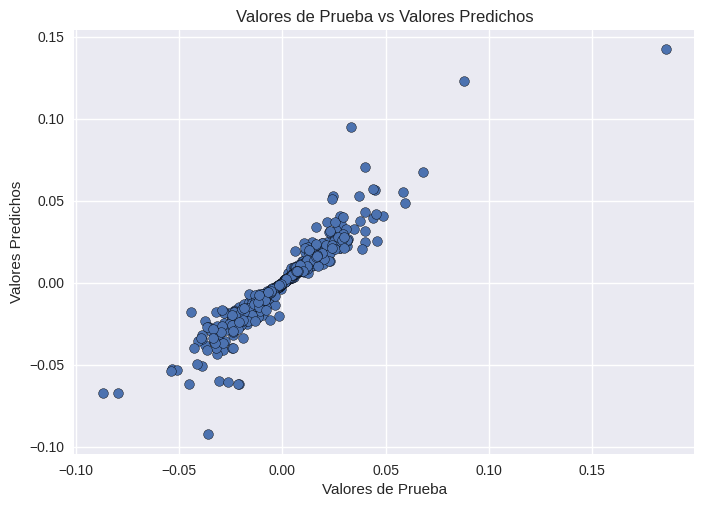

In [ ]:
#comparar valores de prueba y valores predichos
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.xlabel("Valores de Prueba")
plt.ylabel("Valores Predichos")
plt.title("Valores de Prueba vs Valores Predichos")
plt.show()

**Conclusión**: Se observa que el modelo alcanza un Coeficiente de determinación R^2 de 0.8850, lo que significa que es capaz de explicar el 88,50% de la variabilidad de los retornos diarios de MSFT en función de las variables predictoras seleccionadas, lo cual es un buen indicador de la capacidad predictiva del modelo, muy similar al obtenido con el modelo anterior.

Se entiende que los resultados son confiables ya que el Error Cuadrático Medio MSE obtenido se encuentra muy cerca del rango esperado según la validación cruzada. El valor de 3.21e-05 se encuentra cercano aunque fuera del intervalo resultante de acuerdo a la media de 5.22e-05 +- 1.86e-05 obtenida con la validación cruzada, es decir, entre 3.36e-05 y 7.08e-05 aproximadamente. El error está alineado con lo que se podría esperar, lo que sugiere que el modelo generaliza bien y los resultados son consistentes, aunque en mejor medida que con el modelo anterior.


##6.3. Bosque Aleatorio

In [ ]:
#crear el modelo
model = RandomForestRegressor(random_state=42)

In [ ]:
#validación cruzada del modelo
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("MSE scores para cada conjunto: ", -scores)
print("Media MSE: ", -scores.mean())
print("Desviación Estándar MSE: ", scores.std())

MSE scores para cada conjunto:  [3.96482369e-05 2.06226514e-05 1.07373188e-05 2.73299761e-05
 3.93642790e-05]
Media MSE:  2.7540492442697494e-05
Desviación Estándar MSE:  1.1105376086634802e-05


In [ ]:
#entrenar el modelo
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
#realizar predicciones
y_pred = model.predict(X_test)

In [ ]:
#evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Error cuadrático medio:", mse)
print("Coeficiente de determinación (R^2):", r2)

Error cuadrático medio: 1.8902568462027206e-05
Coeficiente de determinación (R^2): 0.9323574119242126


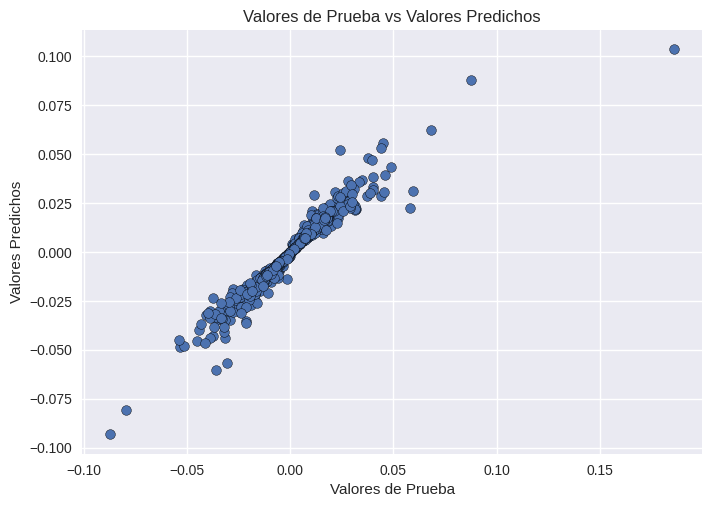

In [ ]:
#comparar valores de prueba y valores predichos
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.xlabel("Valores de Prueba")
plt.ylabel("Valores Predichos")
plt.title("Valores de Prueba vs Valores Predichos")
plt.show()

**Conclusión**: Se observa que el modelo alcanza un Coeficiente de determinación R^2 de 0.9323, lo que significa que es capaz de explicar el 93,23% de la variabilidad de los retornos diarios de MSFT en función de las variables predictoras seleccionadas, lo cual es un muy buen indicador de la capacidad predictiva del modelo, siendo el más alto de los 3 modelos elegidos.

Se entiende que los resultados son confiables ya que el Error Cuadrático Medio MSE obtenido se encuentra dentro del rango esperado según la validación cruzada. El valor de 1.89e-05 se encuentra dentro del intervalo resultante de acuerdo a la media de 2.75e-05 +- 1.11e-05 obtenida con la validación cruzada, es decir, entre 1.59e-05 y 3.81e-05 aproximadamente. El error está bien alineado con lo que se podría esperar, lo que sugiere que el modelo generaliza bien y los resultados son consistentes, siendo incluso el menor de los MSE obtenidos.
